In [87]:
!pip install wordcloud imblearn nltk scikit-learn plotly pandas matplotlib gensim kagglehub catboost joblib lightgbm xgboost -q

# 1. Import libraries

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

import os
import json
import datetime
import math
import warnings
import logging
from collections import defaultdict

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import re

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support, adjusted_rand_score, roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

import xgboost as xgb

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, BatchNormalization, TextVectorization, Embedding, Dense, SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, Conv2D, Flatten, Dropout, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

%matplotlib inline
warnings.filterwarnings('ignore')
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
os.listdir();

# 1. Import data

In [4]:
tweets = pd.read_csv(r"cyberbullying_tweets.csv")
tweets.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

# 3. EDA

In [5]:
print("Unique values in labels:")
display(tweets['cyberbullying_type'].unique())

print("\nSpread of labels:")
display(tweets['cyberbullying_type'].value_counts())

category_counts = tweets['cyberbullying_type'].value_counts()
print("\nSpread of labels by percent:")

display(tweets['cyberbullying_type'].value_counts(normalize = True) * 100)

Unique values in labels:


array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)


Spread of labels:


religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


Spread of labels by percent:


religion               16.770108
age                    16.757527
gender                 16.717689
ethnicity              16.692527
not_cyberbullying      16.658978
other_cyberbullying    16.403170
Name: cyberbullying_type, dtype: float64

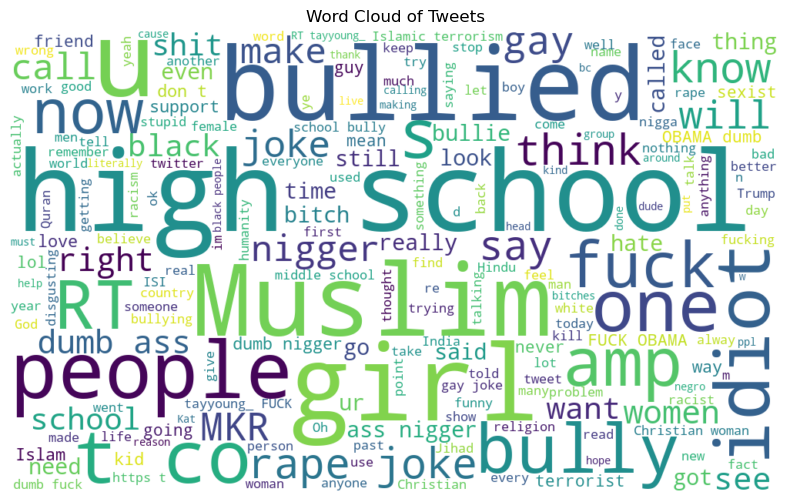

In [6]:
text = ' '.join(tweets['tweet_text'])
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

# 4. Clean the data

## 4.1 Check for duplicates

In [7]:
tweets_adj = tweets.drop_duplicates(subset = "tweet_text", keep = 'first')
print(f"Before: {tweets.shape}")
print(f"After: {tweets_adj.shape}")
print(f"We have taken out {tweets.shape[0] - tweets_adj.shape[0]} duplicated tweets.")

Before: (47692, 2)
After: (46017, 2)
We have taken out 1675 duplicated tweets.


## 4.2 Cleaning the tweets

Text data from social media tends to be a little tricky as many users opt to shorten their word forms or use colloquial terms. We will try to standardise it as much as possible by cleaning the data.

In the following section, we will use a few modules from the `NLTK` library which refers to Natural Language Toolkit.

`Stopwords` are words that are filtered out before processing natural language as they are considered to be noise in text. Removing them generally improves performance but like all data science applications, it can vary from context to context.  

`Stemming` is the process of reducing words to their word stem (base form).  

`Lemmatising`, like stemming, also reduces words to their base form. But it does it with a twist. It uses lexical knowledge bases to ensure that the reduced form is a valid word according to the language. It generally provides more accurate results due to having a more informed analysis.


### 4.2.1 Functions Bank

In [8]:
def clean_text(text, use_lemmatization=True):
    # Remove URLs
    text = remove_URL(text)

    # Remove HTML tags
    text = remove_html(text)

    # Remove Emojis
    text = remove_emoji(text)

    # Convert to lowercase
    text = text.lower()

    # Encode to remove non-ascii characters
    text = text.encode('ascii', 'ignore').decode()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize text
    word_tokens = word_tokenize(text)

    # Remove stop words
    stop = set(stopwords.words('english'))
    filtered_text = [word for word in word_tokens if word not in stop]

    # Lemmatization
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        filtered_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    return ' '.join(filtered_text)

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def get_text_by_label(data, label):
    corpus = []
    filtered_by_label = data[data['cyberbullying_type'] == label]

    for text in filtered_by_label['cleaned_tweet'].str.split():
        for token in text:
            corpus.append(token)

    return corpus

def get_text_freq_by_label(data, label):
    stop = set(stopwords.words('english'))
    label_text = get_text_by_label(data, label)
    dic=defaultdict(int)
    for word in label_text:
        if word not in stop:
            dic[word]+=1

    return dic

def plot_top_k_text_freq_by_label(data, k):
    labels = data['cyberbullying_type'].unique()
    rows = len(labels) // 2
    cols = 2
    fig = sp.make_subplots(rows = rows, cols = cols, subplot_titles = [f"Label {label}" for label in labels])

    for i, label in enumerate(labels):
        corpus_freq = get_text_freq_by_label(data, label)
        top=sorted(corpus_freq.items(), key=lambda x:x[1],reverse=True)[:k]

        row, col = i // cols + 1, i % cols + 1

        for i, (word, count) in enumerate(top):
            fig.add_trace(go.Bar(
            x = [word],
            y = [count],
            text = [count],
            textposition = "outside",
            name = word,
            showlegend = False
        ), row = row, col = col)

    fig.update_layout(title_text="Bar Charts for Word Frequencies (Top K)",
                      showlegend=True)  # A single legend
    fig.show()

### 4.2.2 Actual tweet cleaning process

<div class="alert alert-block alert-info">
NOTE: Let's discuss more on whether we should use lemmatisation below.
</div>


In [9]:
%%time

# Apply functions in the sequence
cleaned_tweets_adj = tweets_adj.copy()
cleaned_tweets_adj['cleaned_tweet'] = cleaned_tweets_adj['tweet_text'].apply(lambda x: clean_text(x, use_lemmatization=False))

CPU times: user 10.3 s, sys: 328 ms, total: 10.6 s
Wall time: 10.6 s


In [10]:
plot_top_k_text_freq_by_label(cleaned_tweets_adj, 10)

In [11]:
cleaned_tweets_adj

tweet_text cyberbullying_type  \
0      In other words #katandandre, your food was cra...  not_cyberbullying   
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
...                                                  ...                ...   
47687  Black ppl aren't expected to do anything, depe...          ethnicity   
47688  Turner did not withhold his disappointment. Tu...          ethnicity   
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity   
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity   
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity   

                                           cleaned_tweet  
0                words katandandre food crapilicious mkr  
1      aussietv white mkr theblock imacelebrityau tod...  
2        xochitlsuckkks classy whore red velvet cupcakes  
3      jasongio meh p thanks heads concerned another ...  
4      rudhoeenglish isis account pretending kurdish ...  
...                                                  ...  
47687  black ppl arent expected anything depended any...  
47688  turner withhold disappointment turner called c...  
47689  swear god dumb nigger bitch got bleach hair re...  
47690  yea fuck rt therealexel youre nigger fucking u...  
47691  bro u got ta chill rt chillshrammy dog fuck kp...  

[46017 rows x 3 columns]

# 5. Embeddings

We used logistic regression to benchmark which embedding method was better.

In [12]:
# Load cleaned tweets dataset
data = pd.read_csv('cleaned_tweets.csv')
texts = data['cleaned_tweet'].astype(str).values
labels = data['cyberbullying_type'].values

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Tokenization and Padding for TensorFlow Embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=29)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=29)

# Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=[tweet.split() for tweet in X_train], vector_size=100, window=5, min_count=1, workers=4)
word2vec_X_train = np.array([np.mean([word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for tweet in X_train])
word2vec_X_test = np.array([np.mean([word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for tweet in X_test])

# GloVe Embeddings
glove_embeddings = {}
with open(r"glove.6B.100d.txt", 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

glove_X_train = np.array([np.mean([glove_embeddings.get(word, np.zeros(100)) for word in tweet.split()], axis=0) for tweet in X_train])
glove_X_test = np.array([np.mean([glove_embeddings.get(word, np.zeros(100)) for word in tweet.split()], axis=0) for tweet in X_test])

# Train and Evaluate Logistic Regression for Each Embedding Type
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1-Score": f1_score(y_test, y_pred, average='weighted', zero_division=1)
    }

# Collect metrics for each embedding type
metrics_word2vec = train_and_evaluate(word2vec_X_train, word2vec_X_test, y_train, y_test)
metrics_glove = train_and_evaluate(glove_X_train, glove_X_test, y_train, y_test)

# Display results in a table format
results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Word2Vec": [metrics_word2vec["Accuracy"], metrics_word2vec["Precision"], metrics_word2vec["Recall"], metrics_word2vec["F1-Score"]],
    "GloVe": [metrics_glove["Accuracy"], metrics_glove["Precision"], metrics_glove["Recall"], metrics_glove["F1-Score"]]
})

print("Embedding Comparison Metrics with Logistic Regression")
print(results)


INFO - 15:56:23: collecting all words and their counts
INFO - 15:56:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:56:23: PROGRESS: at sentence #10000, processed 139889 words, keeping 23152 word types
INFO - 15:56:23: PROGRESS: at sentence #20000, processed 282123 words, keeping 36398 word types
INFO - 15:56:23: PROGRESS: at sentence #30000, processed 422677 words, keeping 47059 word types
INFO - 15:56:23: collected 53664 word types from a corpus of 517928 raw words and 36813 sentences
INFO - 15:56:23: Creating a fresh vocabulary
INFO - 15:56:23: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 53664 unique words (100.00% of original 53664, drops 0)', 'datetime': '2024-11-13T15:56:23.328975', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]', 'platform': 'Linux-5.10.226-214.880.amzn2.x86_64-x86_64-with-glibc2.26', 'event': 'prepare_vocab'}
INFO - 15:56:23: Word2Vec lifecycle even

Embedding Comparison Metrics with Logistic Regression
      Metric  Word2Vec     GloVe
0   Accuracy  0.768688  0.745328
1  Precision  0.757669  0.736553
2     Recall  0.768688  0.745328
3   F1-Score  0.760571  0.740273


In [13]:
# Save
# word2vec_model.save("word2vec.model")

# # Load
# word2vec_model = gensim.models.Word2Vec.load("word2vec.model")

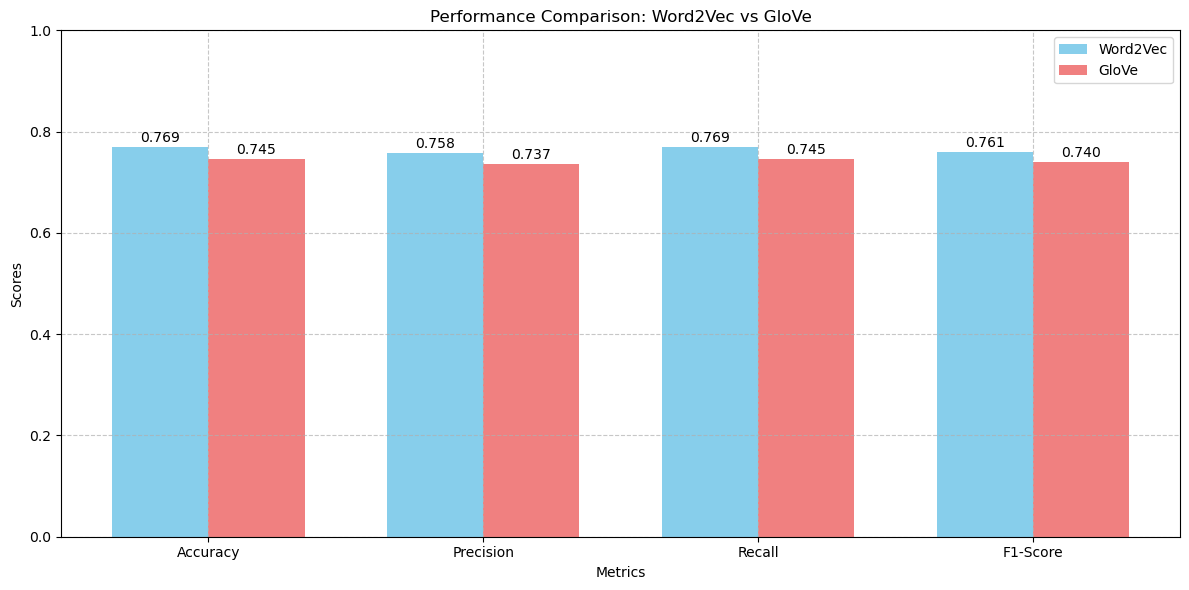

In [14]:
# Set figure size
plt.figure(figsize=(12, 6))

# Set width of bars
bar_width = 0.35

# Set position of bar on X axis
r1 = np.arange(len(results['Metric']))
r2 = [x + bar_width for x in r1]

# Create bars
plt.bar(r1, results['Word2Vec'], color='skyblue', width=bar_width, label='Word2Vec')
plt.bar(r2, results['GloVe'], color='lightcoral', width=bar_width, label='GloVe')

# Add labels
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Comparison: Word2Vec vs GloVe')
plt.xticks([r + bar_width/2 for r in range(len(results['Metric']))], results['Metric'])

# Add value labels on top of each bar
for i, v in enumerate(results['Word2Vec']):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
for i, v in enumerate(results['GloVe']):
    plt.text(i + bar_width, v + 0.01, f'{v:.3f}', ha='center')

# Add legend
plt.legend()

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis limits
plt.ylim(0, 1.0)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# 5. Vectorizers

In [15]:
def get_average_embedding(tokens, model):
    """Compute the average Word2Vec embedding for a list of tokens."""
    valid_embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0).tolist()  # Convert to list
    else:
        return [0] * model.vector_size  # Return a zero vector if no tokens are in the model

# Generate embeddings for each tweet
cleaned_tweets_adj['tweet_embedding'] = cleaned_tweets_adj['cleaned_tweet'].apply(
    lambda tokens: get_average_embedding(tokens, word2vec_model)
)

# Save to CSV
cleaned_tweets_adj.to_csv(r"cleaned_tweets_with_embeddings.csv", index=False)

In [16]:
# Load the dataset
data = pd.read_csv(r"cleaned_tweets_with_embeddings.csv")

# Convert `tweet_embedding` from JSON string back to list format
X_word2vec = np.stack(data['tweet_embedding'].apply(json.loads).values)
y = data['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)

# Proceed with train-test split and model training
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = clf_w2v.predict(X_test_w2v)


In [17]:
# Load the dataset with precomputed embeddings
data = pd.read_csv(r"cleaned_tweets_with_embeddings.csv")

# Ensure embeddings are converted to array format
X_word2vec = np.stack(data['tweet_embedding'].apply(eval).values)  # Using Word2Vec embeddings
y = data['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)  # Target variable

# Splitting the dataset using Word2Vec embeddings
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model using Word2Vec embeddings
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = clf_w2v.predict(X_test_w2v)

# Evaluate the model on Word2Vec embeddings
print("Word2Vec Embedding Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v))

Word2Vec Embedding Model Performance:
Accuracy: 0.8218166014776185
              precision    recall  f1-score   support

           0       0.42      0.00      0.01      1638
           1       0.82      1.00      0.90      7566

    accuracy                           0.82      9204
   macro avg       0.62      0.50      0.45      9204
weighted avg       0.75      0.82      0.74      9204



# Embedding VS Tfidf VS Count Vectorizers

In [18]:
# Load dataset
data = pd.read_csv('cleaned_tweets.csv')

# Fill NaN with an empty string
data['cleaned_tweet'] = data['cleaned_tweet'].fillna('')

# Convert 'cyberbullying_type' into binary numeric values
data['cyberbullying_numeric'] = data['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)

y = data['cyberbullying_numeric']

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(data['cleaned_tweet'])

# Feature extraction using Count Vectorizer
count_vect = CountVectorizer(max_features=500)
X_count = count_vect.fit_transform(data['cleaned_tweet'])

# Split dataset for both vectorizations
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_count, X_test_count, _, _ = train_test_split(X_count, y, test_size=0.2, random_state=42)

# Apply RandomUnderSampler to balance the training data
sampler = RandomUnderSampler(random_state=42)

# Rebalance TF-IDF training set
X_train_tfidf_resampled, y_train_resampled_tfidf = sampler.fit_resample(X_train_tfidf, y_train)

# Rebalance Count Vectorizer training set
X_train_count_resampled, y_train_resampled_count = sampler.fit_resample(X_train_count, y_train)

# Cross-validation setup using StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# Define the raw text data for Word2Vec embeddings
X_raw = data['cleaned_tweet']  # Original text data

# Split the raw text data for Word2Vec embeddings
X_raw_train, X_raw_test, _, _ = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Train Word2Vec model on training data
word2vec_model = Word2Vec(sentences=[tweet.split() for tweet in X_raw_train], vector_size=100, window=5, min_count=1, workers=4)

# Generate averaged Word2Vec embeddings for each tweet in the training and test sets
word2vec_X_train = np.array([
    np.mean([word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    for tweet in X_raw_train
])
word2vec_X_test = np.array([
    np.mean([word2vec_model.wv[word] for word in tweet.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    for tweet in X_raw_test
])

# Rebalance Word2Vec training set
sampler = RandomUnderSampler(random_state=42)
word2vec_X_train_resampled, y_train_resampled_word2vec = sampler.fit_resample(word2vec_X_train, y_train)

INFO - 15:57:11: collecting all words and their counts
INFO - 15:57:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:57:11: PROGRESS: at sentence #10000, processed 139866 words, keeping 23151 word types
INFO - 15:57:11: PROGRESS: at sentence #20000, processed 282077 words, keeping 36397 word types
INFO - 15:57:11: PROGRESS: at sentence #30000, processed 422601 words, keeping 47059 word types
INFO - 15:57:11: collected 53664 word types from a corpus of 517834 raw words and 36813 sentences
INFO - 15:57:11: Creating a fresh vocabulary
INFO - 15:57:11: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 53664 unique words (100.00% of original 53664, drops 0)', 'datetime': '2024-11-13T15:57:11.584910', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:24) [GCC 13.3.0]', 'platform': 'Linux-5.10.226-214.880.amzn2.x86_64-x86_64-with-glibc2.26', 'event': 'prepare_vocab'}
INFO - 15:57:11: Word2Vec lifecycle even

**Logistic Regression**

Logistic Regression is an algorithm that is commonly used for binary classification tasks. It is a straightforward and interpretable model that works well with sparse data and text-based features, especially when paired with techniques such as TF-IDF and Count Vectorization. It is also efficient in terms of computational resources, making it suitable for large datasets.

In [19]:
#Logistic Regression model for TF-IDF with rebalanced training data
logreg_model_tfidf = LogisticRegression(max_iter=1000, random_state=42)
logreg_model_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Logistic Regression model for Count Vectorizer with rebalanced training data
logreg_model_count = LogisticRegression(max_iter=1000, random_state=42)
logreg_model_count.fit(X_train_count_resampled, y_train_resampled_count)

#Logistic Regression model for Word2Vec embeddings with rebalanced training data
logreg_model_word2vec = LogisticRegression(max_iter=1000, random_state=42)
logreg_model_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Predictions on test sets
y_pred_logreg_tfidf = logreg_model_tfidf.predict(X_test_tfidf)
y_pred_logreg_count = logreg_model_count.predict(X_test_count)
y_pred_logreg_word2vec = logreg_model_word2vec.predict(word2vec_X_test)

#Evaluate all models
accuracy_logreg_tfidf = accuracy_score(y_test, y_pred_logreg_tfidf)
accuracy_logreg_count = accuracy_score(y_test, y_pred_logreg_count)
accuracy_logreg_word2vec = accuracy_score(y_test, y_pred_logreg_word2vec)

print("Logistic Regression Test Accuracy for TF-IDF: ", accuracy_logreg_tfidf)
print("Logistic Regression Classification Report for TF-IDF:\n", classification_report(y_test, y_pred_logreg_tfidf))

print("Logistic Regression Test Accuracy for Count Vectorizer: ", accuracy_logreg_count)
print("Logistic Regression Classification Report for Count Vectorizer:\n", classification_report(y_test, y_pred_logreg_count))

print("Logistic Regression Test Accuracy for Word2Vec: ", accuracy_logreg_word2vec)
print("Logistic Regression Classification Report for Word2Vec:\n", classification_report(y_test, y_pred_logreg_word2vec))

#Cross-validation with TF-IDF
print("Cross-validation results for Logistic Regression with TF-IDF:")
cv_scores_logreg_tfidf = cross_val_score(logreg_model_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')
print("Cross-validation Accuracy (Logistic Regression - TF-IDF): ", np.mean(cv_scores_logreg_tfidf))

#Cross-validation with Count Vectorizer
print("Cross-validation results for Logistic Regression with Count Vectorizer:")
cv_scores_logreg_count = cross_val_score(logreg_model_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')
print("Cross-validation Accuracy (Logistic Regression - Count Vectorizer): ", np.mean(cv_scores_logreg_count))

#Cross-validation with Word2Vec embeddings
print("Cross-validation results for Logistic Regression with Word2Vec embeddings:")
cv_scores_logreg_word2vec = cross_val_score(logreg_model_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')
print("Cross-validation Accuracy (Logistic Regression - Word2Vec): ", np.mean(cv_scores_logreg_word2vec))

Logistic Regression Test Accuracy for TF-IDF:  0.8159495871360278
Logistic Regression Classification Report for TF-IDF:
               precision    recall  f1-score   support

           0       0.49      0.90      0.63      1638
           1       0.97      0.80      0.88      7566

    accuracy                           0.82      9204
   macro avg       0.73      0.85      0.76      9204
weighted avg       0.89      0.82      0.83      9204

Logistic Regression Test Accuracy for Count Vectorizer:  0.8159495871360278
Logistic Regression Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.49      0.92      0.64      1638
           1       0.98      0.79      0.88      7566

    accuracy                           0.82      9204
   macro avg       0.73      0.86      0.76      9204
weighted avg       0.89      0.82      0.83      9204

Logistic Regression Test Accuracy for Word2Vec:  0.8082355497609734
Logistic Regress

**Support Vector Machine (SVM)**

SVM is effective for text classification, especially in high-dimensional spaces like those created by TF-IDF or Count Vectorizer. Its ability to maximize the margin between classes makes it suitable for distinguishing between complex patterns.

In [20]:
#SVM with TF-IDF features
svm_tfidf = SVC(kernel='linear', random_state=42)

#Perform cross-validation
print("Cross-validation results for SVM with TF-IDF:")
cv_scores_tfidf = cross_val_score(svm_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (TF-IDF): {np.mean(cv_scores_tfidf)}")

#Train the SVM model using TF-IDF data
svm_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Predictions on TF-IDF test set
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

#Evaluate SVM with TF-IDF
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)
print(f'SVM with TF-IDF Test Accuracy: {accuracy_svm_tfidf}')
print('Classification Report (TF-IDF):')
print(classification_report(y_test, y_pred_svm_tfidf))


#SVM with Count Vectorizer features
svm_count = SVC(kernel='linear', random_state=42)

#Perform cross-validation
print("Cross-validation results for SVM with Count Vectorizer:")
cv_scores_count = cross_val_score(svm_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Count Vectorizer): {np.mean(cv_scores_count)}")

#Train the SVM model using Count Vectorizer data
svm_count.fit(X_train_count_resampled, y_train_resampled_count)

#Predictions on Count Vectorizer test set
y_pred_svm_count = svm_count.predict(X_test_count)

#Evaluate SVM with Count Vectorizer
accuracy_svm_count = accuracy_score(y_test, y_pred_svm_count)
print(f'SVM with Count Vectorizer Test Accuracy: {accuracy_svm_count}')
print('Classification Report (Count Vectorizer):')
print(classification_report(y_test, y_pred_svm_count))


#SVM with Word2Vec embeddings
svm_word2vec = SVC(kernel='linear', random_state=42)

#Perform cross-validation
print("Cross-validation results for SVM with Word2Vec embeddings:")
cv_scores_word2vec = cross_val_score(svm_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Word2Vec): {np.mean(cv_scores_word2vec)}")

#Train the SVM model using Word2Vec embeddings
svm_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Predictions on Word2Vec test set
y_pred_svm_word2vec = svm_word2vec.predict(word2vec_X_test)

#Evaluate SVM with Word2Vec embeddings
accuracy_svm_word2vec = accuracy_score(y_test, y_pred_svm_word2vec)
print(f'SVM with Word2Vec Test Accuracy: {accuracy_svm_word2vec}')
print('Classification Report (Word2Vec):')
print(classification_report(y_test, y_pred_svm_word2vec))

Cross-validation results for SVM with TF-IDF:
Cross-validation Accuracy (TF-IDF): 0.8471968178322428
SVM with TF-IDF Test Accuracy: 0.7991090830073881
Classification Report (TF-IDF):
              precision    recall  f1-score   support

           0       0.47      0.93      0.62      1638
           1       0.98      0.77      0.86      7566

    accuracy                           0.80      9204
   macro avg       0.72      0.85      0.74      9204
weighted avg       0.89      0.80      0.82      9204

Cross-validation results for SVM with Count Vectorizer:
Cross-validation Accuracy (Count Vectorizer): 0.8557707048930242
SVM with Count Vectorizer Test Accuracy: 0.8071490656236419
Classification Report (Count Vectorizer):
              precision    recall  f1-score   support

           0       0.48      0.94      0.63      1638
           1       0.98      0.78      0.87      7566

    accuracy                           0.81      9204
   macro avg       0.73      0.86      0.75      

**CatBoost**

CatBoost is a gradient boosting algorithm that is particularly effective for classification tasks. It handles categorical features well and is less prone to overfitting compared to other boosting methods. It is also efficient, requiring less hyperparameter tuning, and performs well with large datasets.

In [96]:
#Initialize CatBoost parameters
catboost_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'verbose': 0,
    'random_seed': 42,
    'allow_writing_files':False
}

#CatBoost with TF-IDF features
catboost_tfidf = CatBoostClassifier(**catboost_params)

# Perform cross-validation
print("Cross-validation results for CatBoost with TF-IDF:")
cv_scores_catboost_tfidf = cross_val_score(catboost_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (TF-IDF): {np.mean(cv_scores_catboost_tfidf)}")

#Train the CatBoost model using TF-IDF data
catboost_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Predictions on TF-IDF test set
y_pred_catboost_tfidf = catboost_tfidf.predict(X_test_tfidf)

# #Evaluate CatBoost with TF-IDF
accuracy_catboost_tfidf = accuracy_score(y_test, y_pred_catboost_tfidf)
print(f'CatBoost Test Accuracy (TF-IDF): {accuracy_catboost_tfidf}')
print(f'Classification Report (TF-IDF):\n{classification_report(y_test, y_pred_catboost_tfidf)}')


#CatBoost with Count Vectorizer features
catboost_count = CatBoostClassifier(**catboost_params)

#Perform cross-validation
print("Cross-validation results for CatBoost with Count Vectorizer:")
cv_scores_catboost_count = cross_val_score(catboost_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Count Vectorizer): {np.mean(cv_scores_catboost_count)}")

#Train the CatBoost model using Count Vectorizer data
catboost_count.fit(X_train_count_resampled, y_train_resampled_count)

#Predictions on Count Vectorizer test set
y_pred_catboost_count = catboost_count.predict(X_test_count)

#Evaluate CatBoost with Count Vectorizer
accuracy_catboost_count = accuracy_score(y_test, y_pred_catboost_count)
print(f'CatBoost Test Accuracy (Count Vectorizer): {accuracy_catboost_count}')
print(f'Classification Report (Count Vectorizer):\n{classification_report(y_test, y_pred_catboost_count)}')


#CatBoost with Word2Vec Embeddings
catboost_word2vec = CatBoostClassifier(**catboost_params)

#Perform cross-validation
print("Cross-validation results for CatBoost with Word2Vec:")
cv_scores_catboost_word2vec = cross_val_score(catboost_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Word2Vec): {np.mean(cv_scores_catboost_word2vec)}")

#Train the CatBoost model using Word2Vec data
catboost_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Predictions on Word2Vec test set
y_pred_catboost_word2vec = catboost_word2vec.predict(word2vec_X_test)

#Evaluate CatBoost with Word2Vec
accuracy_catboost_word2vec = accuracy_score(y_test, y_pred_catboost_word2vec)
print(f'CatBoost Test Accuracy (Word2Vec): {accuracy_catboost_word2vec}')
print(f'Classification Report (Word2Vec):\n{classification_report(y_test, y_pred_catboost_word2vec)}')


Cross-validation results for CatBoost with TF-IDF:
Cross-validation Accuracy (TF-IDF): 0.8586283520556753
CatBoost Test Accuracy (TF-IDF): 0.800412863972186
Classification Report (TF-IDF):
              precision    recall  f1-score   support

           0       0.47      0.95      0.63      1638
           1       0.99      0.77      0.86      7566

    accuracy                           0.80      9204
   macro avg       0.73      0.86      0.75      9204
weighted avg       0.89      0.80      0.82      9204

Cross-validation results for CatBoost with Count Vectorizer:
Cross-validation Accuracy (Count Vectorizer): 0.8617244096473644
CatBoost Test Accuracy (Count Vectorizer): 0.8035636679704476
Classification Report (Count Vectorizer):
              precision    recall  f1-score   support

           0       0.47      0.95      0.63      1638
           1       0.99      0.77      0.87      7566

    accuracy                           0.80      9204
   macro avg       0.73      0.86   

**Random Forest**

Random Forest is an ensemble learning method that builds multiple decision trees to make a final prediction. We use it here to classify the text into categories such as cyberbullying or not cyberbullying based on the features extracted from the text.

We believe that Random Forest is well-suited for text classification tasks because it handles high-dimensional data does not make strong assumptions about the data's structure and can work effectively with sparse features like TF-IDF or Count Vectorizer outputs.

Its ability to handle noisy data and provide insights into feature importance should make it a good choice for text-related tasks.

In [24]:
#Initialize the Random Forest classifier with TF-IDF features
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)

#Perform cross-validation
print("Cross-validation results for Random Forest with TF-IDF:")
cv_scores_rf_tfidf = cross_val_score(rf_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (TF-IDF): {np.mean(cv_scores_rf_tfidf)}")

#Train the model using the TF-IDF features
rf_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Make predictions
y_pred_tfidf_rf = rf_tfidf.predict(X_test_tfidf)

#Evaluate the model
accuracy_tfidf_rf = accuracy_score(y_test, y_pred_tfidf_rf)
print(f'TF-IDF - Random Forest Test Accuracy: {accuracy_tfidf_rf}')
print(f'Classification Report (TF-IDF):\n{classification_report(y_test, y_pred_tfidf_rf)}')




#Initialize the Random Forest classifier with Count Vectorizer features
rf_count = RandomForestClassifier(n_estimators=100, random_state=42)

#Perform cross-validation
print("Cross-validation results for Random Forest with Count Vectorizer:")
cv_scores_rf_count = cross_val_score(rf_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Count Vectorizer): {np.mean(cv_scores_rf_count)}")

#Train the model using the Count Vectorizer
rf_count.fit(X_train_count_resampled, y_train_resampled_count)

#Make predictions
y_pred_count_rf = rf_count.predict(X_test_count)

#Evaluate the model
accuracy_count_rf = accuracy_score(y_test, y_pred_count_rf)
print(f'Count Vectorizer - Random Forest Test Accuracy: {accuracy_count_rf}')
print(f'Classification Report (Count Vectorizer):\n{classification_report(y_test, y_pred_count_rf)}')



#Initialize the Random Forest classifier with Word2Vec embeddings
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)

#Perform cross-validation
print("Cross-validation results for Random Forest with Word2Vec:")
cv_scores_rf_word2vec = cross_val_score(rf_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Word2Vec): {np.mean(cv_scores_rf_word2vec)}")

#Train the model using the Word2Vec embeddings
rf_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Make predictions
y_pred_word2vec_rf = rf_word2vec.predict(word2vec_X_test)

#Evaluate the model
accuracy_word2vec_rf = accuracy_score(y_test, y_pred_word2vec_rf)
print(f'Word2Vec - Random Forest Test Accuracy: {accuracy_word2vec_rf}')
print(f'Classification Report (Word2Vec):\n{classification_report(y_test, y_pred_word2vec_rf)}')


Cross-validation results for Random Forest with TF-IDF:
Cross-validation Accuracy (TF-IDF): 0.8571988980924644
TF-IDF - Random Forest Test Accuracy: 0.8183398522381573
Classification Report (TF-IDF):
              precision    recall  f1-score   support

           0       0.49      0.92      0.64      1638
           1       0.98      0.80      0.88      7566

    accuracy                           0.82      9204
   macro avg       0.74      0.86      0.76      9204
weighted avg       0.89      0.82      0.84      9204

Cross-validation results for Random Forest with Count Vectorizer:
Cross-validation Accuracy (Count Vectorizer): 0.8495795352824741
Count Vectorizer - Random Forest Test Accuracy: 0.8186657974793567
Classification Report (Count Vectorizer):
              precision    recall  f1-score   support

           0       0.49      0.90      0.64      1638
           1       0.97      0.80      0.88      7566

    accuracy                           0.82      9204
   macro avg   

**K-Means**

K-Means is typically used for unsupervised learning, so it is unable to produce an accuracy rating. Thus, we will compute how well the clusters match the original labels using adjusted Rand index (ARI).

Adjusted Rand Index (ARI) measures the similarity between two clusterings by comparing the predicted clusters (from K-Means) to the true labels (y_test). It adjusts for the chance grouping of elements, providing a more accurate measure than the simple Rand Index.

ARI score ranges from -1 to 1. 1: Perfect clustering. The clusters exactly match the true labels. 0: Random clustering, no similarity to the true labels. Negative values: Worse than random clustering. The clusters are poorly aligned with the true labels.

In [28]:
#Initialize the K-Means model for TFIDF
kmeans_tfidf = KMeans(n_clusters=2, random_state=42)

#Fit the K-Means model using the TF-IDF features
kmeans_tfidf.fit(X_train_tfidf_resampled)

#Predict clusters on the test set
y_pred_tfidf_kmeans = kmeans_tfidf.predict(X_test_tfidf)

#Evaluate the clustering performance using ARI
ari_tfidf = adjusted_rand_score(y_test, y_pred_tfidf_kmeans)
print(f'TF-IDF - K-Means Adjusted Rand Index: {ari_tfidf}')



#Initialize the K-Means model for Count Vectorizers
kmeans_count = KMeans(n_clusters=2, random_state=42)

#Fit the K-Means model
kmeans_count.fit(X_train_count_resampled)

#Predict clusters on the test set
y_pred_count_kmeans = kmeans_count.predict(X_test_count)

#Evaluate the clustering performance using ARI
ari_count = adjusted_rand_score(y_test, y_pred_count_kmeans)
print(f'Count Vectorizer - K-Means Adjusted Rand Index: {ari_count}')

TF-IDF - K-Means Adjusted Rand Index: -0.05681997004571294
Count Vectorizer - K-Means Adjusted Rand Index: -0.023520150222239918


**XGBoost**

XGBoost is a powerful boosting algorithm that builds a series of decision trees, with each tree correcting errors from the previous ones. This iterative process enables it to learn complex patterns and achieve high accuracy. XGBoost is especially effective with high-dimensional data, such as features derived from TF-IDF or Count Vectorization. Its optimization for speed, memory, and handling class imbalance makes it well-suited for text classification tasks like cyberbullying detection.

In [29]:
#Initialize XGBoost classifier for TF-IDF
xgb_model_tfidf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

#Perform cross-validation
print("Cross-validation results for XGBoost with TF-IDF:")
cv_scores_xgb_tfidf = cross_val_score(xgb_model_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (TF-IDF): {np.mean(cv_scores_xgb_tfidf)} ± {np.std(cv_scores_xgb_tfidf)}")

#Train the model using TF-IDF features
xgb_model_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Make predictions
y_pred_tfidf = xgb_model_tfidf.predict(X_test_tfidf)

#Evaluate the model with TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"XGBoost Accuracy (TF-IDF): {accuracy_tfidf}")
print(f"Classification Report (TF-IDF):\n {classification_report(y_test, y_pred_tfidf)}")



#Initialize XGBoost classifier for Count Vectorizers
xgb_model_count = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

#Perform cross-validation
print("Cross-validation results for XGBoost with Count Vectorizer:")
cv_scores_xgb_count = cross_val_score(xgb_model_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Count Vectorizer): {np.mean(cv_scores_xgb_count)} ± {np.std(cv_scores_xgb_count)}")

#Train the model using Count Vectorizer features
xgb_model_count.fit(X_train_count_resampled, y_train_resampled_count)

#Make predictions on the test set
y_pred_count = xgb_model_count.predict(X_test_count)

#Evaluate the model with Count Vectorizer
accuracy_count = accuracy_score(y_test, y_pred_count)
print(f"XGBoost Accuracy (Count Vectorizer): {accuracy_count}")
print(f"Classification Report (Count Vectorizer):\n {classification_report(y_test, y_pred_count)}")



#Initialize XGBoost classifier for Word2Vec
xgb_model_word2vec = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

#Perform cross-validation
print("Cross-validation results for XGBoost with Word2Vec embeddings:")
cv_scores_xgb_word2vec = cross_val_score(xgb_model_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')
print(f"Cross-validation Accuracy (Word2Vec): {np.mean(cv_scores_xgb_word2vec)} ± {np.std(cv_scores_xgb_word2vec)}")

#Train the model
xgb_model_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Make predictions
y_pred_word2vec = xgb_model_word2vec.predict(word2vec_X_test)

# Evaluate the model with Word2Vec embeddings
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(f"XGBoost Accuracy (Word2Vec): {accuracy_word2vec}")
print(f"Classification Report (Word2Vec):\n {classification_report(y_test, y_pred_word2vec)}")

Cross-validation results for XGBoost with TF-IDF:
Cross-validation Accuracy (TF-IDF): 0.862437749788822 ± 0.012558979275196275
XGBoost Accuracy (TF-IDF): 0.809973924380704
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.48      0.95      0.64      1638
           1       0.99      0.78      0.87      7566

    accuracy                           0.81      9204
   macro avg       0.73      0.87      0.76      9204
weighted avg       0.90      0.81      0.83      9204

Cross-validation results for XGBoost with Count Vectorizer:
Cross-validation Accuracy (Count Vectorizer): 0.8659308218919021 ± 0.010785435595217467
XGBoost Accuracy (Count Vectorizer): 0.8109517601043025
Classification Report (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.48      0.95      0.64      1638
           1       0.99      0.78      0.87      7566

    accuracy                           0.81      9204
   

**LightGBM**

LightGBM is a fast, efficient boosting algorithm that builds decision trees sequentially to boost performance and minimise errors in classification tasks. It's optimized for handling large datasets and complex, high-dimensional data, such as TF-IDF or Count Vectorization. It is particularly suitable for cyberbullying detection as it manages imbalanced data well and offers high accuracy and speed.

In [30]:
# Best parameters from tuning using RandomizedSearchCV
best_params = {
    'subsample': 0.5,
    'num_leaves': 30,
    'n_estimators': 150,
    'min_child_samples': 20,
    'learning_rate': 0.046415888336127774,
    'colsample_bytree': 0.7
}



#Initialize LightGBM model for TF-IDF
lgbm_model_tfidf = LGBMClassifier(**best_params, random_state=42, verbose=-1)

#Cross-validation
cv_scores_tfidf = cross_val_score(lgbm_model_tfidf, X_train_tfidf_resampled, y_train_resampled_tfidf, cv=kf, scoring='accuracy')

#Train the model
lgbm_model_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

#Make predictions on the test set
y_pred_tfidf = lgbm_model_tfidf.predict(X_test_tfidf)

#Evaluate the model with TF-IDF
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"LGBM Accuracy (TF-IDF): {accuracy_tfidf}")
print(f"Cross-Validation Accuracy (TF-IDF): {cv_scores_tfidf.mean()} (± {cv_scores_tfidf.std()})")
print("Classification Report (TF-IDF):\n", classification_report(y_test, y_pred_tfidf))



# Initialize LightGBM model for Count Vectorizer
lgbm_model_count = LGBMClassifier(**best_params, random_state=42, verbose=-1)

# Convert the Count Vectorizer output to float32 (LightGBM expects floating-point values for the features)
X_train_count_resampled = X_train_count_resampled.astype('float32')
X_test_count = X_test_count.astype('float32')

#Cross-validation
cv_scores_count = cross_val_score(lgbm_model_count, X_train_count_resampled, y_train_resampled_count, cv=kf, scoring='accuracy')

#Train the model
lgbm_model_count.fit(X_train_count_resampled, y_train_resampled_count)

# Make predictions
y_pred_count = lgbm_model_count.predict(X_test_count)

# Evaluate the model with Count Vectorizer
accuracy_count = accuracy_score(y_test, y_pred_count)
print(f"LGBM Accuracy (Count Vectorizer): {accuracy_count}")
print(f"Cross-Validation Accuracy (Count Vectorizer): {cv_scores_count.mean()} (± {cv_scores_count.std()})")
print("Classification Report (Count Vectorizer):\n", classification_report(y_test, y_pred_count))



#Initialize LightGBM model for Word2Vec embeddings
lgbm_model_word2vec = LGBMClassifier(**best_params, random_state=42, verbose=-1)

# Cross-validation
cv_scores_word2vec = cross_val_score(lgbm_model_word2vec, word2vec_X_train_resampled, y_train_resampled_word2vec, cv=kf, scoring='accuracy')

# Train the model
lgbm_model_word2vec.fit(word2vec_X_train_resampled, y_train_resampled_word2vec)

#Make predictions
y_pred_word2vec = lgbm_model_word2vec.predict(word2vec_X_test)

#Evaluate the model with Word2Vec embeddings
accuracy_word2vec = accuracy_score(y_test, y_pred_word2vec)
print(f"LGBM Accuracy (Word2Vec): {accuracy_word2vec}")
print(f"Cross-Validation Accuracy (Word2Vec): {cv_scores_word2vec.mean()} (± {cv_scores_word2vec.std()})")
print("Classification Report (Word2Vec):\n", classification_report(y_test, y_pred_word2vec))

LGBM Accuracy (TF-IDF): 0.809322033898305
Cross-Validation Accuracy (TF-IDF): 0.863628541170241 (± 0.011618604014462136)
Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.48      0.95      0.64      1638
           1       0.99      0.78      0.87      7566

    accuracy                           0.81      9204
   macro avg       0.73      0.86      0.75      9204
weighted avg       0.90      0.81      0.83      9204

LGBM Accuracy (Count Vectorizer): 0.8122555410691004
Cross-Validation Accuracy (Count Vectorizer): 0.8645021874251422 (± 0.012232089673559371)
Classification Report (Count Vectorizer):
               precision    recall  f1-score   support

           0       0.49      0.95      0.64      1638
           1       0.99      0.78      0.87      7566

    accuracy                           0.81      9204
   macro avg       0.74      0.87      0.76      9204
weighted avg       0.90      0.81      0.83      9204

LGBM A

In [31]:
# Function to plot ROC-AUC and Precision-Recall curves
def plot_model_performance(model, X_test, y_test, model_name="Model"):
    # Check if model has predict_proba or decision_function for probability scores
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test)
    else:
        raise ValueError("Model does not have predict_proba or decision_function methods.")

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot(ax=ax1)
    ax1.set_title(f'{model_name} ROC Curve (AUC = {roc_auc:.2f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=model_name).plot(ax=ax2)
    ax2.set_title(f'{model_name} Precision-Recall Curve (PR-AUC = {pr_auc:.2f})')

    plt.tight_layout()
    plt.show()

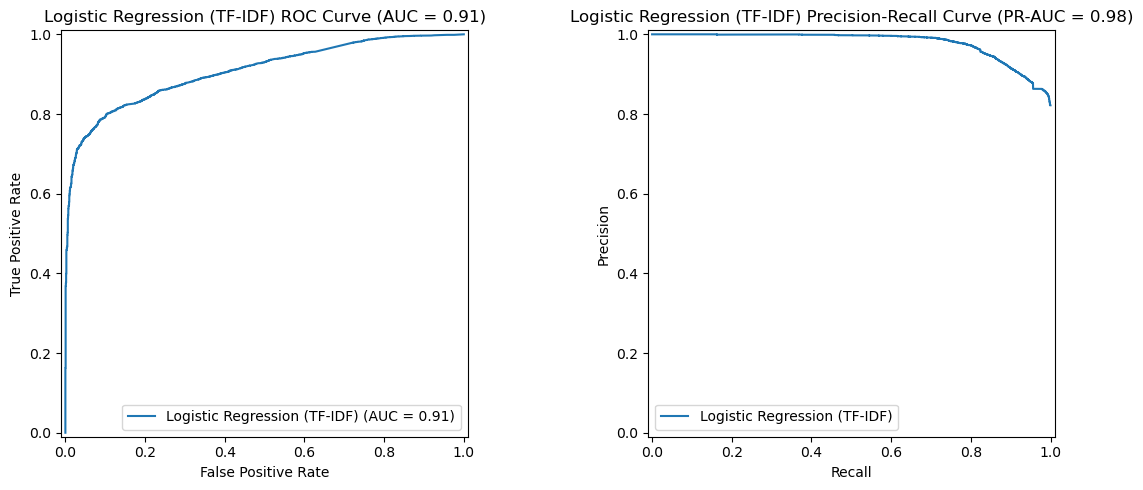

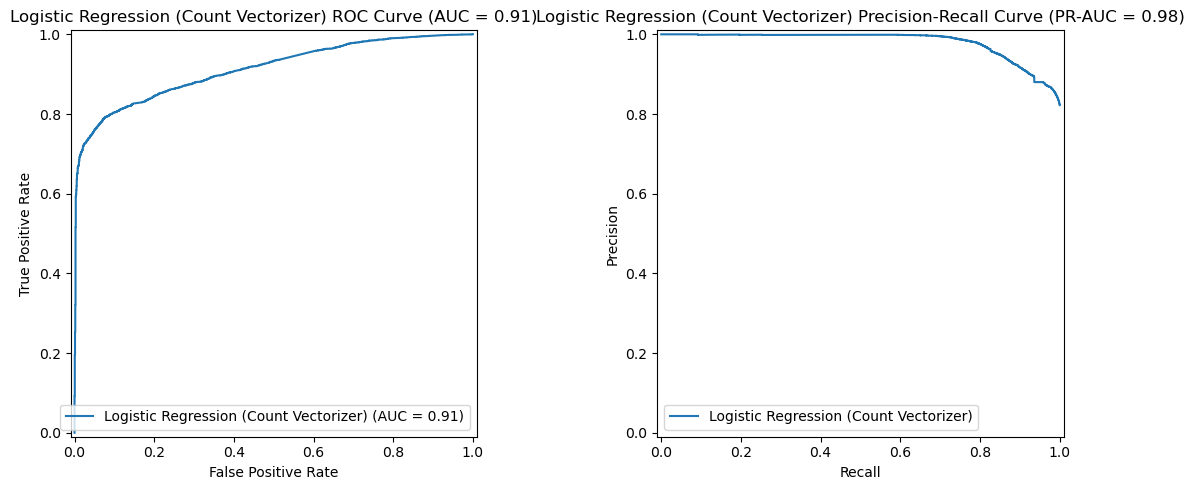

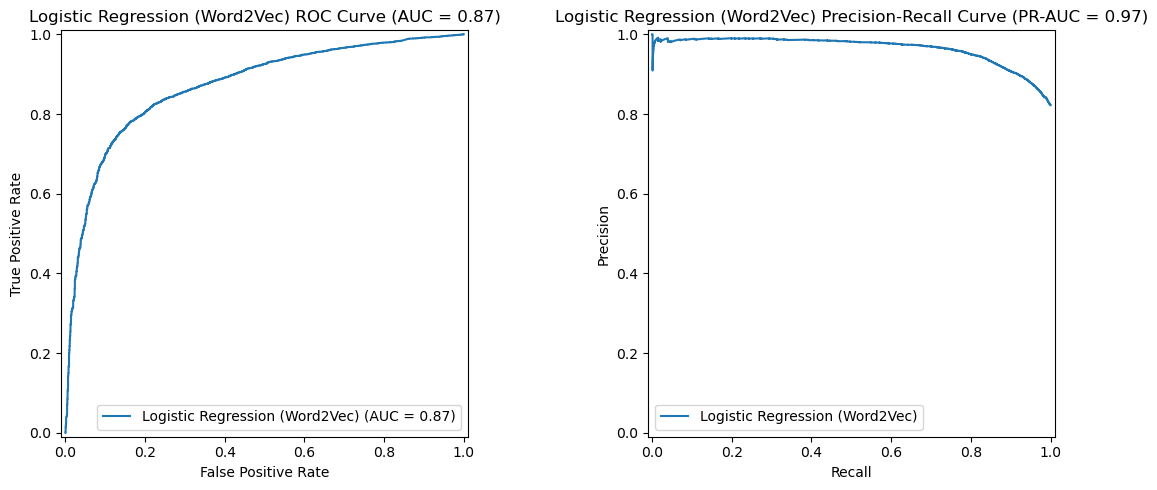

In [32]:
#Plotting for Logistic Regression (TF-IDF)
plot_model_performance(logreg_model_tfidf, X_test_tfidf, y_test, model_name="Logistic Regression (TF-IDF)")

#Plotting for Logistic Regression (Count Vectorizer)
plot_model_performance(logreg_model_count, X_test_count, y_test, model_name="Logistic Regression (Count Vectorizer)")

#Plotting for Logistic Regression (Word2Vec)
plot_model_performance(logreg_model_word2vec, word2vec_X_test, y_test, model_name="Logistic Regression (Word2Vec)")

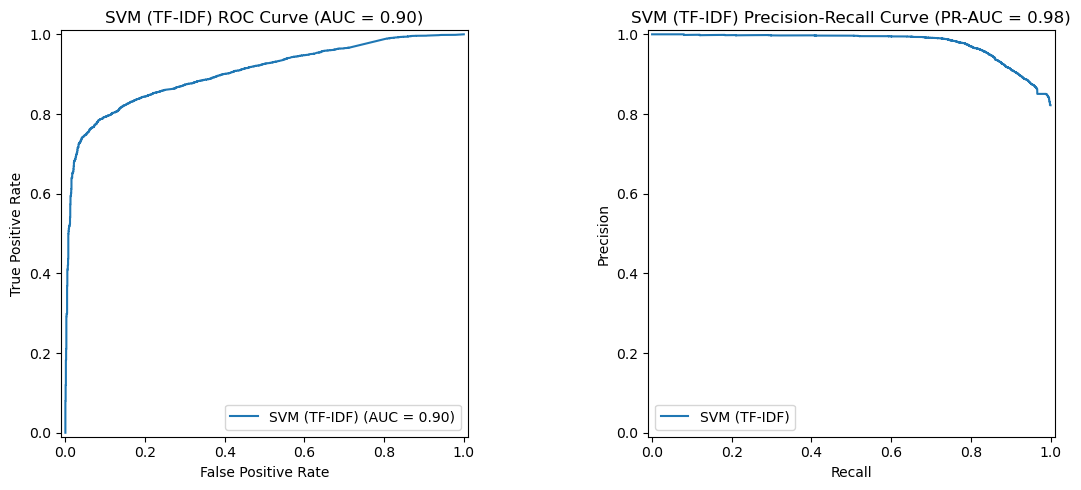

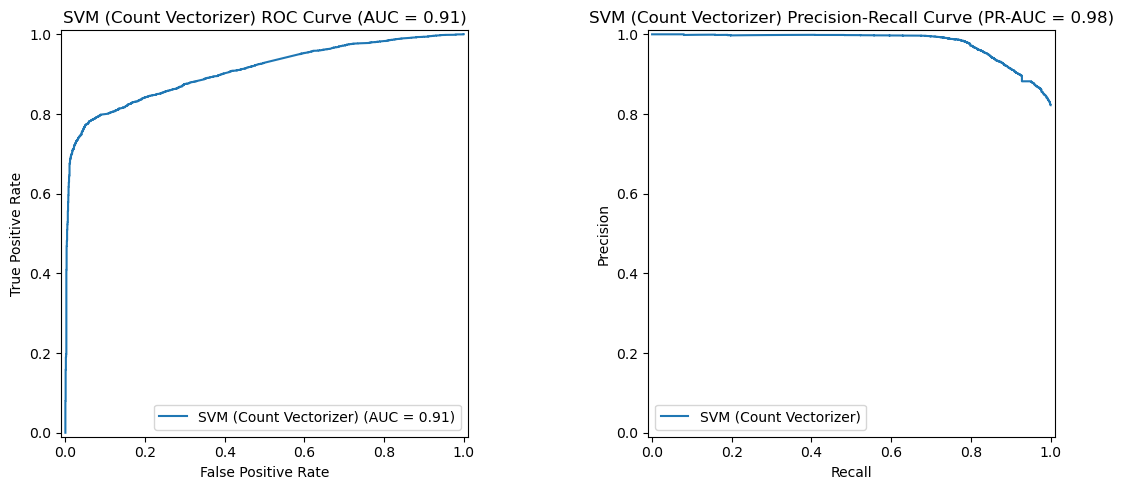

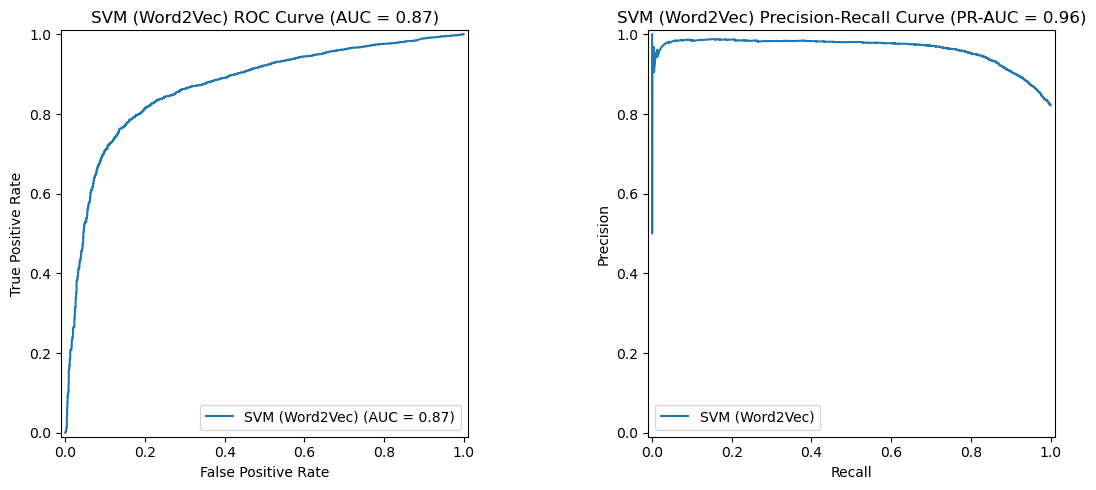

In [33]:
#Plotting for SVM (TF-IDF)
plot_model_performance(svm_tfidf, X_test_tfidf, y_test, model_name="SVM (TF-IDF)")

#Plotting for SVM (Count Vectorizer)
plot_model_performance(svm_count, X_test_count, y_test, model_name="SVM (Count Vectorizer)")

#Plotting for SVM (Word2Vec)
plot_model_performance(svm_word2vec, word2vec_X_test, y_test, model_name="SVM (Word2Vec)")

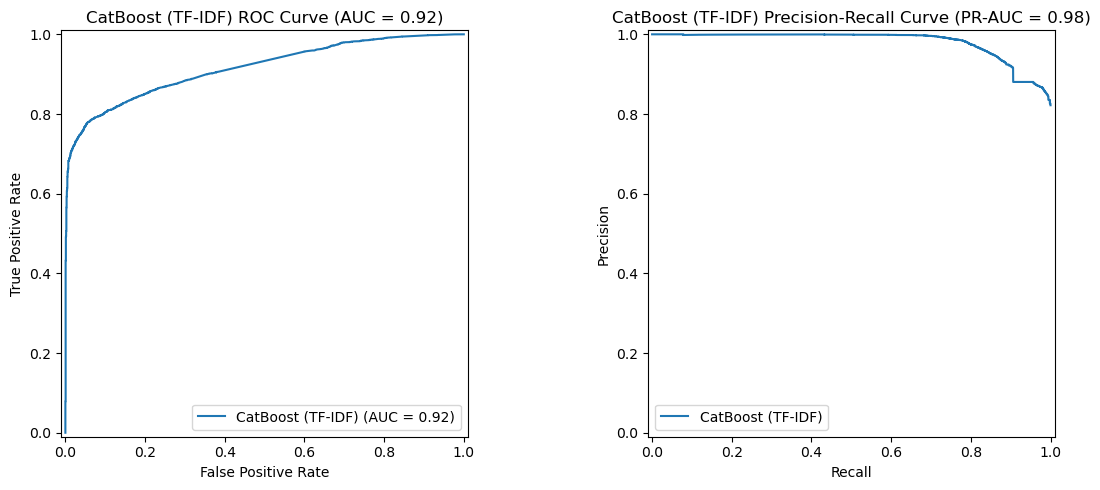

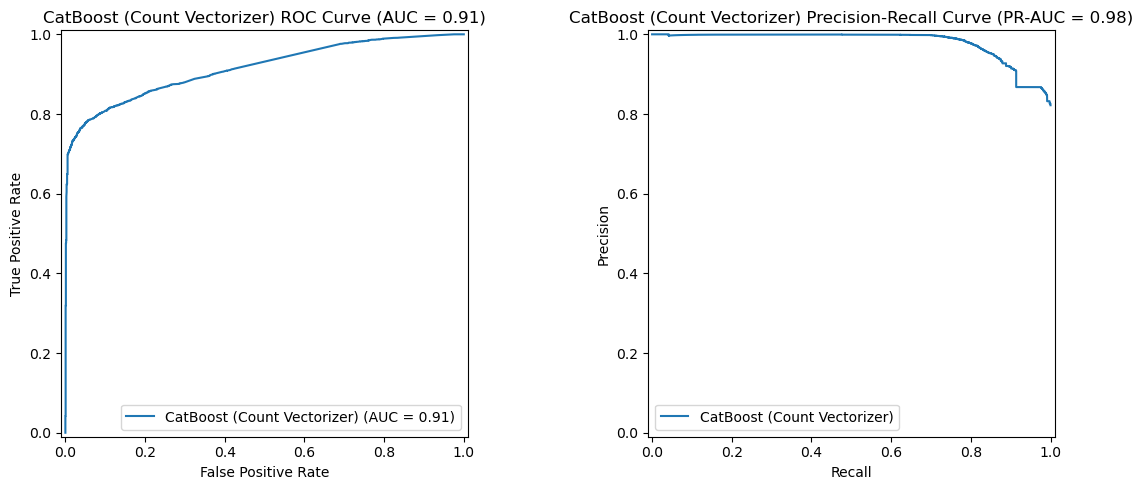

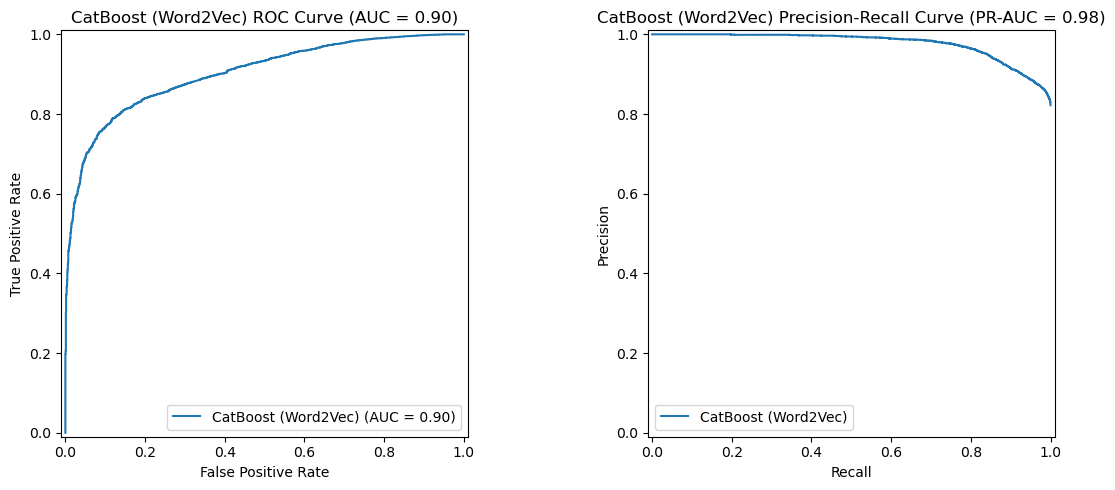

In [97]:
#Plotting for CatBoost (TF-IDF)
plot_model_performance(catboost_tfidf, X_test_tfidf, y_test, model_name="CatBoost (TF-IDF)")

#Plotting for CatBoost (Count Vectorizer)
plot_model_performance(catboost_count, X_test_count, y_test, model_name="CatBoost (Count Vectorizer)")

#Plotting for CatBoost (Word2Vec)
plot_model_performance(catboost_word2vec, word2vec_X_test, y_test, model_name="CatBoost (Word2Vec)")

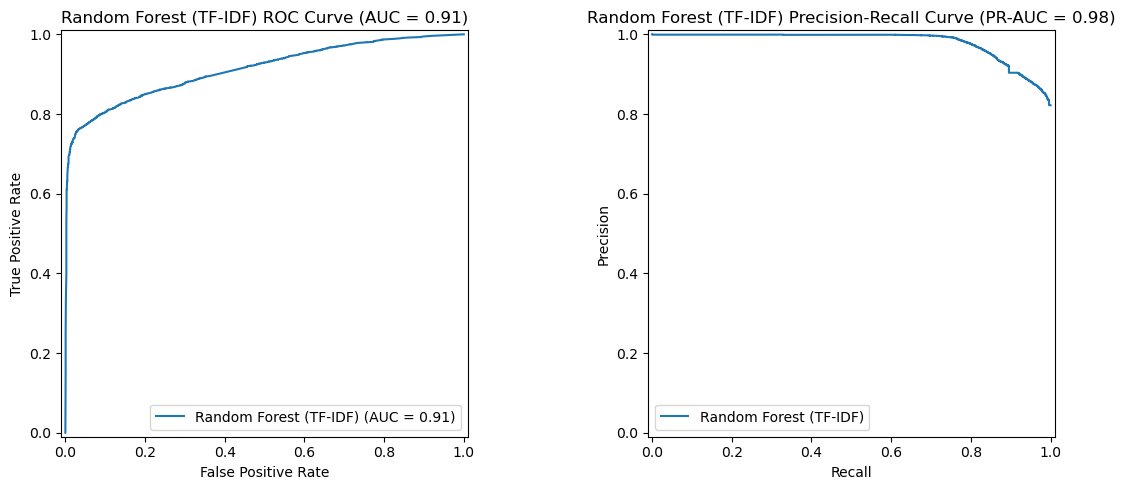

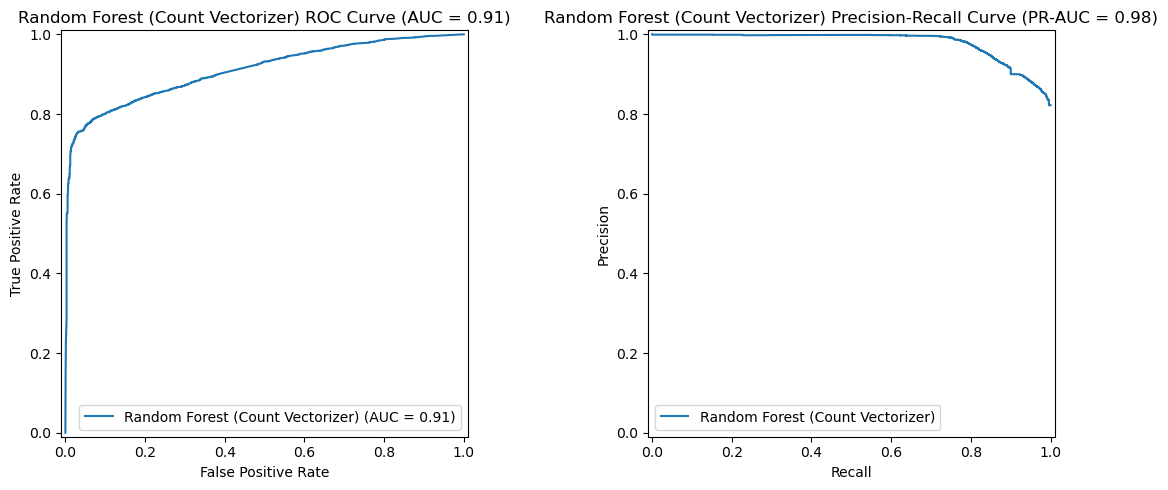

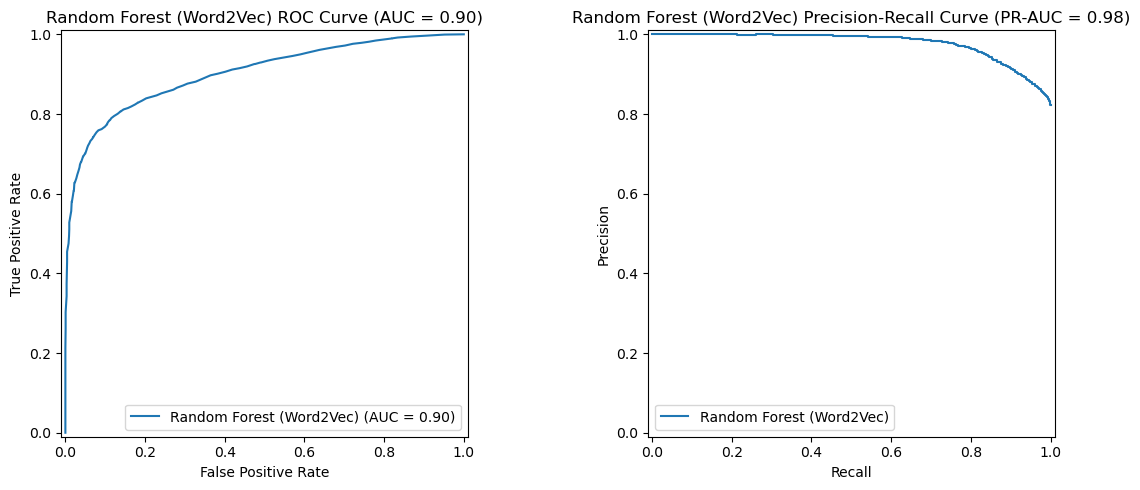

In [35]:
#Plotting for Random Forest (TF-IDF)
plot_model_performance(rf_tfidf, X_test_tfidf, y_test, model_name="Random Forest (TF-IDF)")

#Plotting for Random Forest (Count Vectorizer)
plot_model_performance(rf_count, X_test_count, y_test, model_name="Random Forest (Count Vectorizer)")

#Plotting for Random Forest (Word2Vec)
plot_model_performance(rf_word2vec, word2vec_X_test, y_test, model_name="Random Forest (Word2Vec)")

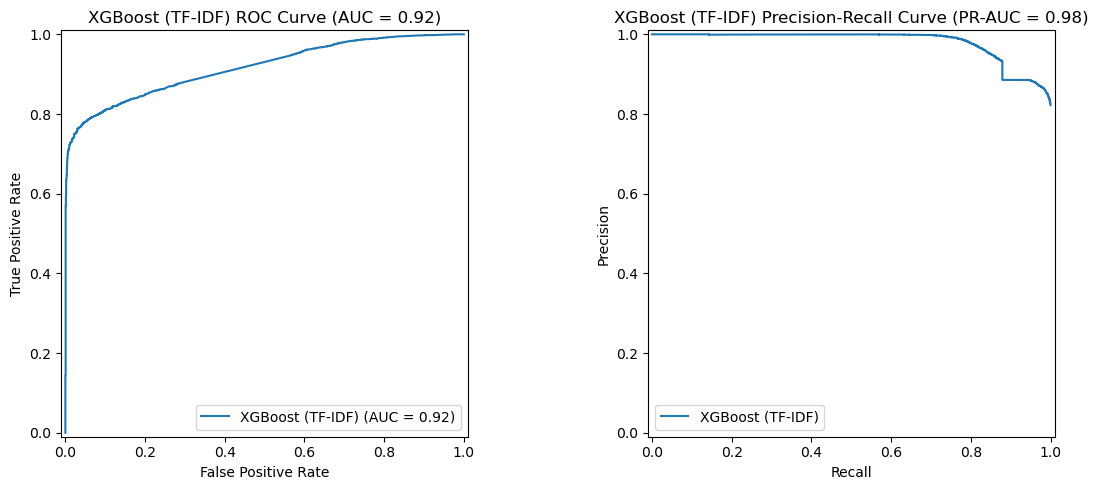

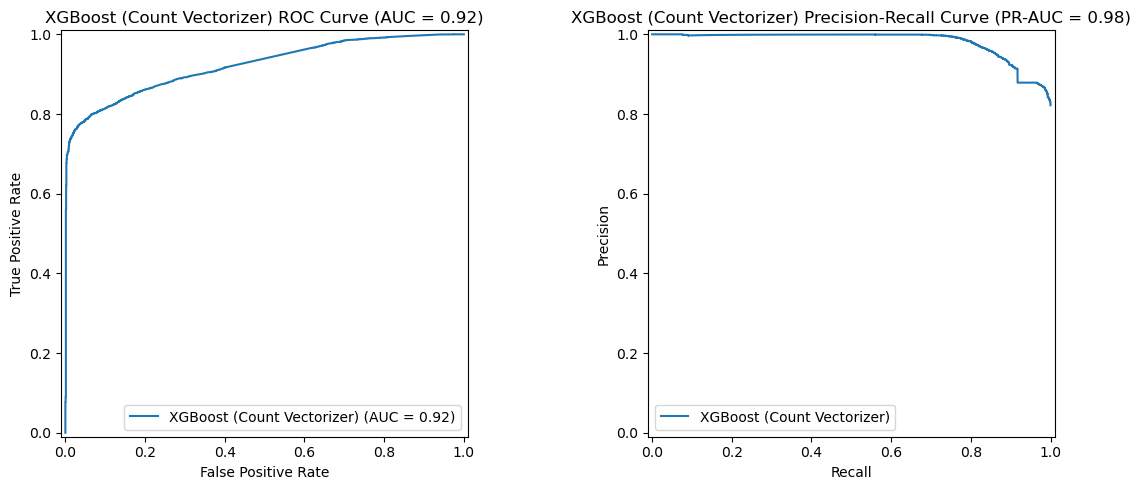

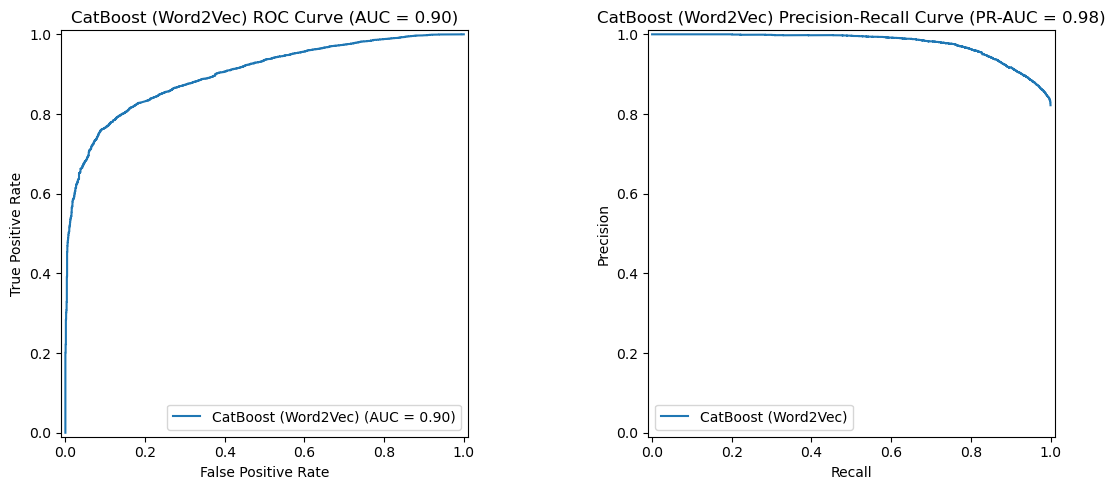

In [36]:
#Plotting for XGBoost (TF-IDF)
plot_model_performance(xgb_model_tfidf, X_test_tfidf, y_test, model_name="XGBoost (TF-IDF)")

#Plotting for XGBoost (Count Vectorizer)
plot_model_performance(xgb_model_count, X_test_count, y_test, model_name="XGBoost (Count Vectorizer)")

#Plotting for XGBoost (Word2Vec)
plot_model_performance(xgb_model_word2vec, word2vec_X_test, y_test, model_name="CatBoost (Word2Vec)")

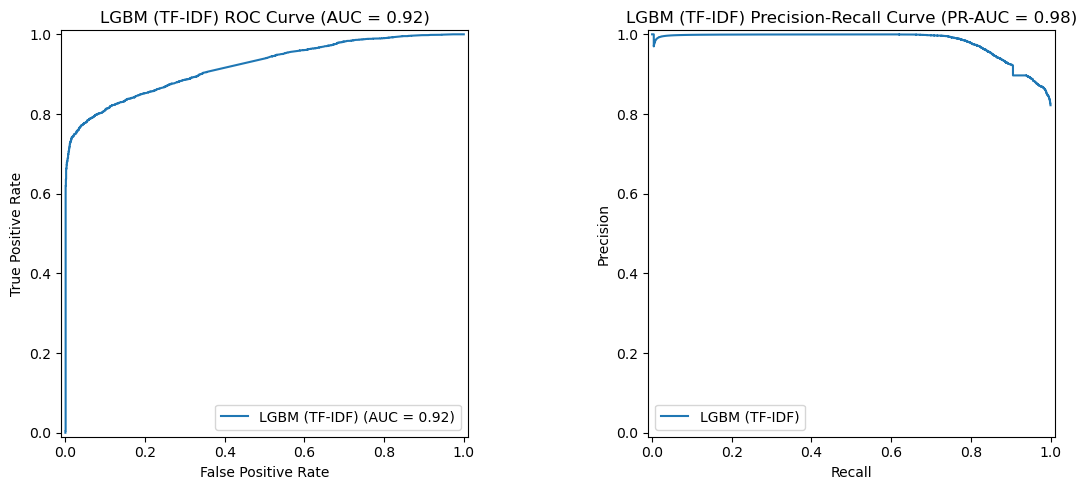

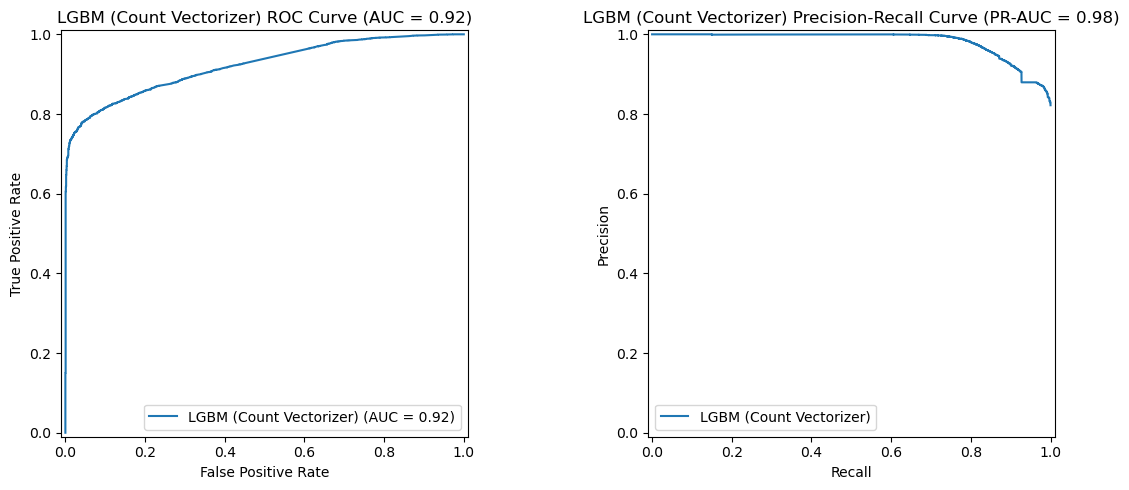

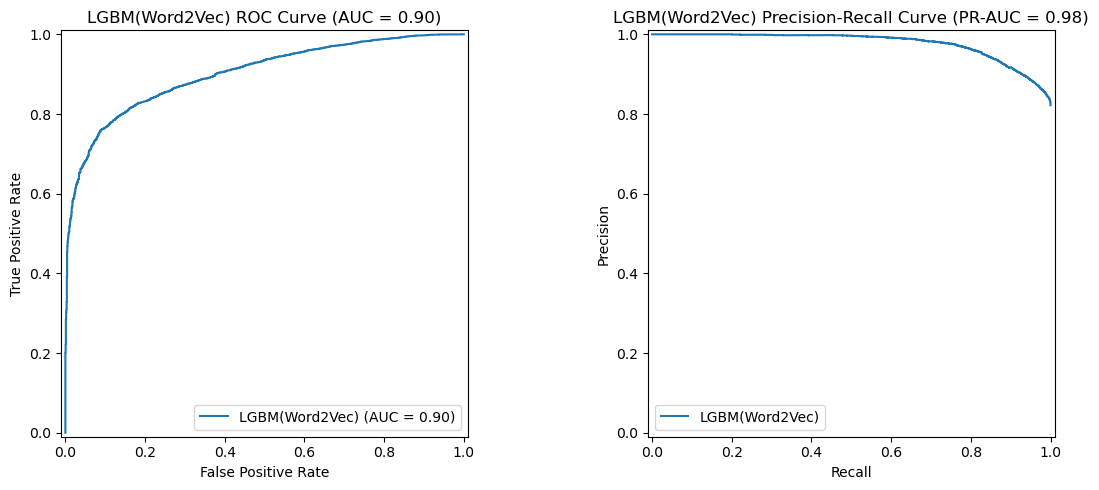

In [37]:
#Plotting for LGBM (TF-IDF)
plot_model_performance(lgbm_model_tfidf, X_test_tfidf, y_test, model_name="LGBM (TF-IDF)")

#Plotting for LGBM (Count Vectorizer)
plot_model_performance(lgbm_model_count, X_test_count, y_test, model_name="LGBM (Count Vectorizer)")

#Plotting for LGBM (Word2Vec)
plot_model_performance(xgb_model_word2vec, word2vec_X_test, y_test, model_name="LGBM(Word2Vec)")

# 7. Neural Network

# Functions

In [38]:
def calculate_results(y_true, y_pred_probs):
    """
    Calculate binary classification metrics

    Args:
        y_true: True labels (0 or 1)
        y_pred_probs: Predicted probabilities from model
    """
    # Convert probabilities to binary predictions
    y_preds = (y_pred_probs > 0.5).astype(int)

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_preds) * 100

    # Calculate precision, recall, and f1 for binary classification
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true,
        y_preds,
        average="binary"  # Changed from "weighted" to "binary"
    )

    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

# Binary Precision Metric
def precision_m(y_true, y_pred):
    """
    Calculate precision for binary classification
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Binary Recall Metric
def recall_m(y_true, y_pred):
    """
    Calculate recall for binary classification
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Binary F1 Score Metric
def f1_m(y_true, y_pred):
    """
    Calculate F1 score for binary classification
    """
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Function to calculate PR-AUC, ROC-AUC
def calculate_pr_roc_auc(y_true, y_pred_probs):
    # Calculate PR curve and AUC for PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    pr_auc = auc(recall, precision)

    # Calculate ROC curve and AUC for ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot PR curve
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='g', label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Return AUC values
    return pr_auc, roc_auc

In [39]:
data = cleaned_tweets_adj.copy()
data['cyberbullying_type_encoded'] = np.where(data['cyberbullying_type'] == 'not_cyberbullying', 0, 1)
data.head()

tweet_text cyberbullying_type  \
0  In other words #katandandre, your food was cra...  not_cyberbullying   
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   

                                       cleaned_tweet  \
0            words katandandre food crapilicious mkr   
1  aussietv white mkr theblock imacelebrityau tod...   
2    xochitlsuckkks classy whore red velvet cupcakes   
3  jasongio meh p thanks heads concerned another ...   
4  rudhoeenglish isis account pretending kurdish ...   

                                     tweet_embedding  \
0  [-0.7222623825073242, 0.4283173978328705, -0.0...   
1  [-0.6307440996170044, 0.4102171063423157, 0.01...   
2  [-0.34724709391593933, 0.373214989900589, 0.04...   
3  [-0.5683870315551758, 0.4400818645954132, 0.01...   
4  [-0.6228558421134949, 0.3620021939277649, 0.00...   

   cyberbullying_type_encoded  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0

In [40]:
number_of_unique_words = len(set(' '.join(data['cleaned_tweet'].fillna('').astype(str)).split()))
print(number_of_unique_words)

61819


In [41]:
vocab_size = number_of_unique_words

In [42]:
avg_len_of_tweets_words = np.mean(data['cleaned_tweet'].fillna('').apply(lambda x: len(x.split())))
print(f"Average length of tweets: {avg_len_of_tweets_words}")

percentile_95_words = np.percentile(data['cleaned_tweet'].fillna('').apply(lambda x: len(x.split())), 95)
print(f"95th percentile of tweet length: {percentile_95_words}")

Average length of tweets: 14.039550600864898
95th percentile of tweet length: 29.0


In [43]:
max_length = int(percentile_95_words)

# Preparing our data

In [44]:
X = data['cleaned_tweet'].fillna('').astype(str)
y = data['cyberbullying_type_encoded']

# split the data into separate train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# change to numpy
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 36813 samples
Test set: 9204 samples


In [45]:
# convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# batch size
batch_size = 64

# add shuffle, batch, and prefetch for efficient training
train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  # No need to shuffle test

W0000 00:00:1731514783.095214    3160 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [46]:
int_text_vectorizer = TextVectorization(max_tokens=vocab_size,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [47]:
int_text_vectorizer.adapt(X_train)

In [48]:
# Get the vocabulary size from the TextVectorization layer
print(f"Vocabulary size of int_text_vectorizer: {int_text_vectorizer.vocabulary_size()}")

Vocabulary size of int_text_vectorizer: 53666


In [49]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Models

## Embedding and Global Max Pooling

In [50]:
vocab = int_text_vectorizer.get_vocabulary()
vocab_size = len(vocab)
embedding_dim = word2vec_model.vector_size

# Initialize embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill embedding matrix with Word2Vec weights
for i, word in enumerate(vocab):
    try:
        embedding_matrix[i] = word2vec_model.wv[word]
    except KeyError:
        # Random initialization for unknown words
        embedding_matrix[i] = np.random.normal(scale=0.1, size=(embedding_dim,))

inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

# Use Word2Vec weights in Embedding layer
token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,  # Change to match Word2Vec dimensions
    weights=[embedding_matrix],  # Initialize with Word2Vec weights
    mask_zero=True,
    trainable=False  # Set to False
)(int_text_vectors)

maxpool_1 = GlobalMaxPooling1D()(token_embeddings)
outputs_1 = Dense(1, activation='sigmoid')(maxpool_1)
model_1 = Model(inputs=inputs, outputs=outputs_1)

In [51]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

In [52]:
history_1 = model_1.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 2s 2ms/step - loss: 0.3287 - f1_m: 0.9112 - val_loss: 0.3142 - val_f1_m: 0.9109
Epoch 2/10
576/576 [==============================] - 1s 2ms/step - loss: 0.3039 - f1_m: 0.9135 - val_loss: 0.3099 - val_f1_m: 0.9080
Epoch 3/10
576/576 [==============================] - 1s 2ms/step - loss: 0.2974 - f1_m: 0.9126 - val_loss: 0.3023 - val_f1_m: 0.9093
Epoch 4/10
576/576 [==============================] - 1s 2ms/step - loss: 0.2936 - f1_m: 0.9130 - val_loss: 0.2990 - val_f1_m: 0.9099
Epoch 5/10
576/576 [==============================] - 1s 2ms/step - loss: 0.2907 - f1_m: 0.9129 - val_loss: 0.2965 - val_f1_m: 0.9102
Epoch 6/10
576/576 [==============================] - 1s 2ms/step - loss: 0.2883 - f1_m: 0.9131 - val_loss: 0.2971 - val_f1_m: 0.9094
Epoch 7/10
576/576 [==============================] - 1s 2ms/step - loss: 0.2865 - f1_m: 0.9133 - val_loss: 0.2935 - val_f1_m: 0.9107
Epoch 8/10
576/576 [==============================] - 1s 2ms/s

In [53]:
model_1_pred_probs = model_1.predict(X_test)
model_1_results = calculate_results(y_test, model_1_pred_probs)
model_1_results

288/288 [==============================] - 0s 1ms/step


{'accuracy': 85.07170795306388,
 'precision': 0.8818450912678836,
 'recall': 0.9450171821305842,
 'f1': 0.9123389051933137}

In [54]:
threshold = 0.5
model_1_preds = (model_1_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_1_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_1_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

              precision    recall  f1-score   support

     Class 0       0.62      0.42      0.50      1638
     Class 1       0.88      0.95      0.91      7566

    accuracy                           0.85      9204
   macro avg       0.75      0.68      0.70      9204
weighted avg       0.84      0.85      0.84      9204



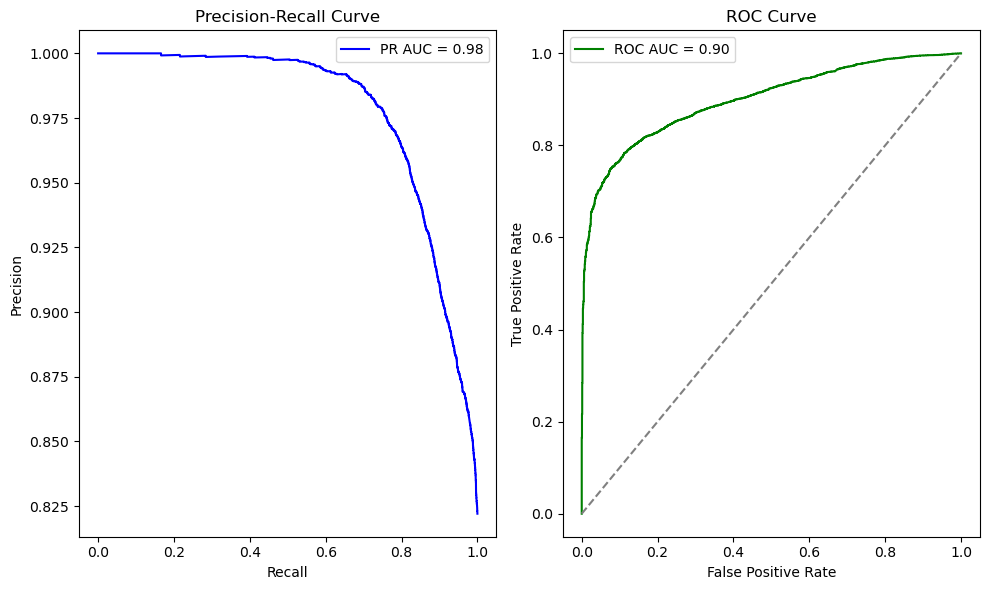

PR AUC: 0.98
ROC AUC: 0.90


In [55]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_1_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Long Short-Term Memory (LSTM)

**LSTM** (Long Short-Term Memory) networks are a type of recurrent neural network capable of learning long-term dependencies in text data, making them effective for analyzing sequences and patterns in cyberbullying detection.

In [56]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

lstm_2 = LSTM(64)(token_embeddings)
outputs_2 =  Dense(1, activation='sigmoid')(lstm_2)
model_2 = Model(inputs=inputs, outputs=outputs_2)


model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

In [57]:
history_2 = model_2.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10


2024-11-13 16:20:01.394852: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


576/576 [==============================] - 13s 17ms/step - loss: 0.2900 - f1_m: 0.9137 - val_loss: 0.2667 - val_f1_m: 0.9183
Epoch 2/10
576/576 [==============================] - 9s 15ms/step - loss: 0.2609 - f1_m: 0.9195 - val_loss: 0.2607 - val_f1_m: 0.9167
Epoch 3/10
576/576 [==============================] - 9s 15ms/step - loss: 0.2530 - f1_m: 0.9223 - val_loss: 0.2543 - val_f1_m: 0.9211
Epoch 4/10
576/576 [==============================] - 9s 15ms/step - loss: 0.2479 - f1_m: 0.9237 - val_loss: 0.2587 - val_f1_m: 0.9195
Epoch 5/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2436 - f1_m: 0.9254 - val_loss: 0.2535 - val_f1_m: 0.9229
Epoch 6/10
576/576 [==============================] - 9s 15ms/step - loss: 0.2409 - f1_m: 0.9256 - val_loss: 0.2527 - val_f1_m: 0.9228
Epoch 7/10
576/576 [==============================] - 9s 15ms/step - loss: 0.2376 - f1_m: 0.9264 - val_loss: 0.2511 - val_f1_m: 0.9205
Epoch 8/10
576/576 [==============================] - 9s 15ms/ste

In [59]:
model_2_pred_probs = model_2.predict(X_test)

threshold = 0.5
model_2_preds = (model_2_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_2_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_2_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

     Class 0       0.64      0.58      0.61      1638
     Class 1       0.91      0.93      0.92      7566

    accuracy                           0.87      9204
   macro avg       0.77      0.75      0.76      9204
weighted avg       0.86      0.87      0.86      9204



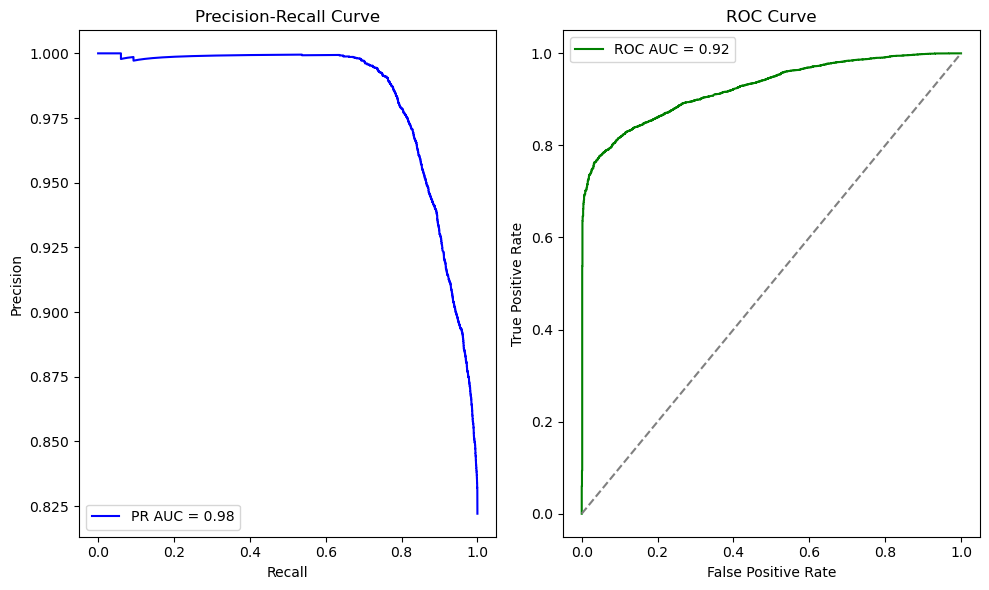

PR AUC: 0.98
ROC AUC: 0.92


In [60]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_2_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Gated Recurrent Unit (GRU)

**GRU** (Gated Recurrent Unit) networks are similar to LSTMs but with a simpler architecture; they efficiently capture sequential dependencies in text, aiding in identifying abusive or harmful language associated with cyberbullying.

In [61]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

gru_3 = GRU(64)(token_embeddings)
outputs_3 =  Dense(1, activation='sigmoid')(gru_3)
model_3 = Model(inputs=inputs, outputs=outputs_3)


model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_3 = model_3.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 12s 16ms/step - loss: 0.2967 - f1_m: 0.9154 - val_loss: 0.2830 - val_f1_m: 0.9078
Epoch 2/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2647 - f1_m: 0.9179 - val_loss: 0.2625 - val_f1_m: 0.9189
Epoch 3/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2552 - f1_m: 0.9215 - val_loss: 0.2577 - val_f1_m: 0.9188
Epoch 4/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2502 - f1_m: 0.9233 - val_loss: 0.2581 - val_f1_m: 0.9170
Epoch 5/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2456 - f1_m: 0.9245 - val_loss: 0.2546 - val_f1_m: 0.9223
Epoch 6/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2423 - f1_m: 0.9246 - val_loss: 0.2505 - val_f1_m: 0.9215
Epoch 7/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2383 - f1_m: 0.9248 - val_loss: 0.2500 - val_f1_m: 0.9207
Epoch 8/10
576/576 [==============================] - 

In [65]:
model_3_pred_probs = model_3.predict(X_test)

threshold = 0.5
model_3_preds = (model_3_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_3_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_3_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

     Class 0       0.65      0.57      0.61      1638
     Class 1       0.91      0.93      0.92      7566

    accuracy                           0.87      9204
   macro avg       0.78      0.75      0.76      9204
weighted avg       0.86      0.87      0.87      9204



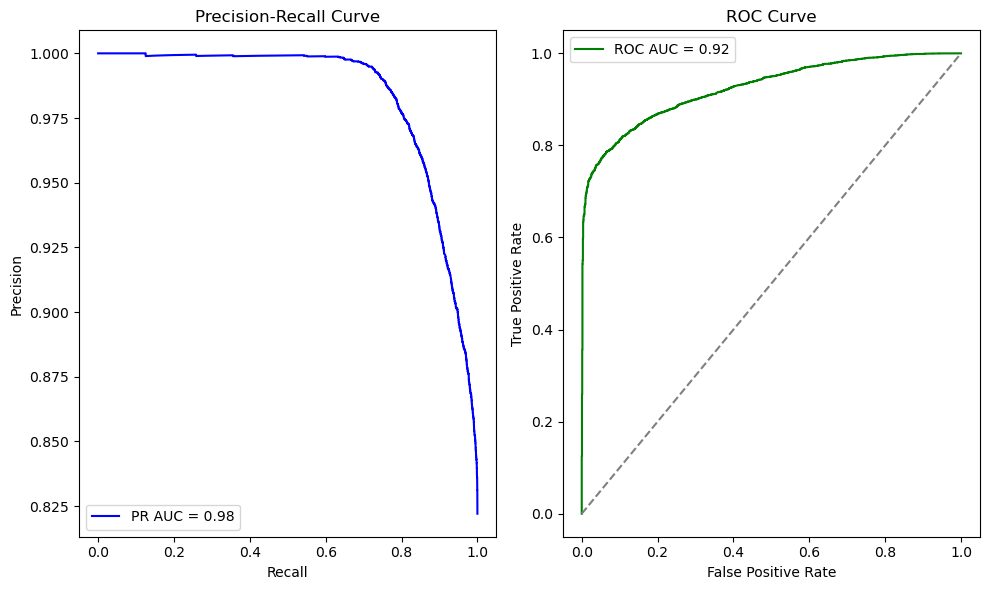

PR AUC: 0.98
ROC AUC: 0.92


In [66]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_3_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Bi-Directional GRU

**Bidirectional GRU** combines the efficiency of GRUs with bidirectional processing, enabling the model to understand context from both ends of a text sequence, thereby improving the identification of cyberbullying content.

In [67]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

bidirectional_gru_4 = Bidirectional(GRU(64))(token_embeddings)
outputs_4 =  Dense(1, activation='sigmoid')(bidirectional_gru_4)
model_4 = Model(inputs=inputs, outputs=outputs_4)


model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_4 = model_4.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 17s 20ms/step - loss: 0.2961 - f1_m: 0.9122 - val_loss: 0.2768 - val_f1_m: 0.9094
Epoch 2/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2611 - f1_m: 0.9204 - val_loss: 0.2571 - val_f1_m: 0.9191
Epoch 3/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2517 - f1_m: 0.9224 - val_loss: 0.2619 - val_f1_m: 0.9182
Epoch 4/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2466 - f1_m: 0.9239 - val_loss: 0.2537 - val_f1_m: 0.9218
Epoch 5/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2429 - f1_m: 0.9247 - val_loss: 0.2501 - val_f1_m: 0.9198
Epoch 6/10
576/576 [==============================] - 10s 16ms/step - loss: 0.2376 - f1_m: 0.9269 - val_loss: 0.2499 - val_f1_m: 0.9192
Epoch 7/10
576/576 [==============================] - 9s 16ms/step - loss: 0.2342 - f1_m: 0.9272 - val_loss: 0.2517 - val_f1_m: 0.9205
Epoch 8/10
576/576 [==============================] -

In [68]:
model_4_pred_probs = model_4.predict(X_test)

threshold = 0.5
model_4_preds = (model_4_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_4_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_4_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

     Class 0       0.66      0.53      0.59      1638
     Class 1       0.90      0.94      0.92      7566

    accuracy                           0.87      9204
   macro avg       0.78      0.73      0.75      9204
weighted avg       0.86      0.87      0.86      9204



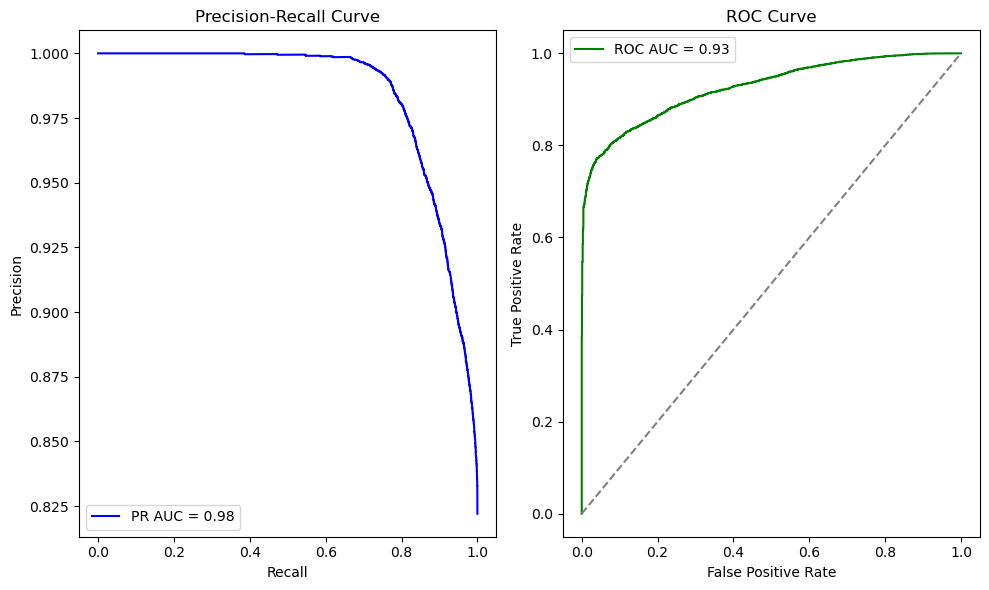

PR AUC: 0.98
ROC AUC: 0.93


In [69]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_4_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Convolutional Neural Network (CNN) 1D

**1D CNN** (One-Dimensional Convolutional Neural Network) applies convolutional operations over sequences to extract local features like phrases or n-grams, which can highlight specific patterns indicative of cyberbullying in text data.

In [70]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

conv1d_5 = Conv1D(filters=32, kernel_size=5, activation='relu')(token_embeddings)
maxpool1d_5 = GlobalMaxPool1D()(conv1d_5)
outputs_5 =  Dense(1, activation='sigmoid')(maxpool1d_5)
model_5 = Model(inputs=inputs, outputs=outputs_5)


model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_5 = model_5.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)


Epoch 1/10
576/576 [==============================] - 3s 4ms/step - loss: 0.3037 - f1_m: 0.9098 - val_loss: 0.2845 - val_f1_m: 0.9151
Epoch 2/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2723 - f1_m: 0.9184 - val_loss: 0.2828 - val_f1_m: 0.9163
Epoch 3/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2660 - f1_m: 0.9202 - val_loss: 0.2779 - val_f1_m: 0.9145
Epoch 4/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2619 - f1_m: 0.9204 - val_loss: 0.2769 - val_f1_m: 0.9186
Epoch 5/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2567 - f1_m: 0.9217 - val_loss: 0.2827 - val_f1_m: 0.9169
Epoch 6/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2532 - f1_m: 0.9228 - val_loss: 0.2775 - val_f1_m: 0.9128
Epoch 7/10
576/576 [==============================] - 2s 3ms/step - loss: 0.2506 - f1_m: 0.9238 - val_loss: 0.2812 - val_f1_m: 0.9162


In [71]:
model_5_pred_probs = model_5.predict(X_test)

threshold = 0.5
model_5_preds = (model_5_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_5_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_5_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

     Class 0       0.72      0.34      0.47      1638
     Class 1       0.87      0.97      0.92      7566

    accuracy                           0.86      9204
   macro avg       0.80      0.66      0.69      9204
weighted avg       0.85      0.86      0.84      9204



In [ ]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_5_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Convolutional Neural Network (CNN) 2D

**2D CNN** (Two-Dimensional Convolutional Neural Network) is primarily designed for image data but can be adapted to text represented as matrices; however, it's less common for cyberbullying detection compared to 1D CNNs.

In [72]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

reshape_6 = Reshape((29,100, 1))(token_embeddings)
conv2d_6 = Conv2D(filters=32, kernel_size=5, activation='relu')(reshape_6)
maxpool2d_6 = MaxPooling2D(pool_size=(2, 2))(conv2d_6)
flatten_6 = Flatten()(maxpool2d_6)
relu_dense_6 = Dense(64, activation = 'relu')(flatten_6)
outputs_6 =  Dense(1, activation='sigmoid')(relu_dense_6)
model_6 = Model(inputs=inputs, outputs=outputs_6)


model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_6 = model_6.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 9s 14ms/step - loss: 0.2974 - f1_m: 0.9100 - val_loss: 0.2900 - val_f1_m: 0.9147
Epoch 2/10
576/576 [==============================] - 8s 13ms/step - loss: 0.2716 - f1_m: 0.9170 - val_loss: 0.2791 - val_f1_m: 0.9154
Epoch 3/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2643 - f1_m: 0.9191 - val_loss: 0.2727 - val_f1_m: 0.9182
Epoch 4/10
576/576 [==============================] - 8s 14ms/step - loss: 0.2595 - f1_m: 0.9209 - val_loss: 0.2677 - val_f1_m: 0.9182
Epoch 5/10
576/576 [==============================] - 8s 13ms/step - loss: 0.2551 - f1_m: 0.9218 - val_loss: 0.2703 - val_f1_m: 0.9145
Epoch 6/10
576/576 [==============================] - 8s 13ms/step - loss: 0.2511 - f1_m: 0.9229 - val_loss: 0.2694 - val_f1_m: 0.9183
Epoch 7/10
576/576 [==============================] - 8s 13ms/step - loss: 0.2459 - f1_m: 0.9240 - val_loss: 0.2748 - val_f1_m: 0.9168


In [73]:
model_6_pred_probs = model_6.predict(X_test)

threshold = 0.5
model_6_preds = (model_6_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_6_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_6_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.67      0.45      0.54      1638
     Class 1       0.89      0.95      0.92      7566

    accuracy                           0.86      9204
   macro avg       0.78      0.70      0.73      9204
weighted avg       0.85      0.86      0.85      9204



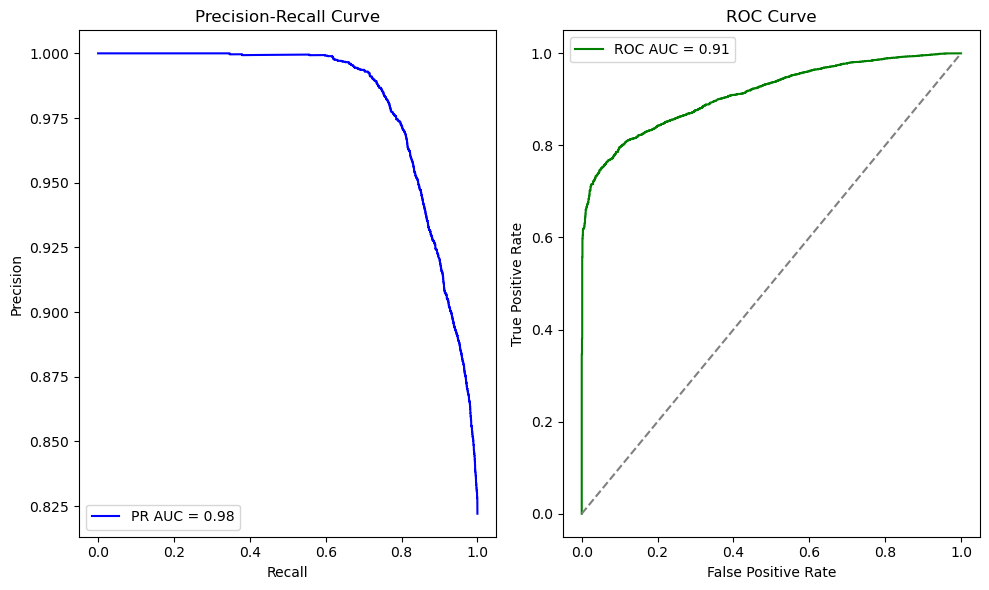

PR AUC: 0.98
ROC AUC: 0.91


In [74]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_6_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Recurrent Neural Network (RNN)

**Simple RNN** (Recurrent Neural Network) processes sequences of text by passing information from one time step to the next, allowing it to capture patterns over time; in cyberbullying detection, it can identify sequential relationships in language but may struggle with long-term dependencies due to issues like vanishing gradients compared to more advanced models like LSTM or GRU.

In [75]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

rnn_7 = SimpleRNN(64)(token_embeddings)
outputs_7 =  Dense(1, activation='sigmoid')(rnn_7)
model_7 = Model(inputs=inputs, outputs=outputs_7)


model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_7 = model_7.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 6s 9ms/step - loss: 0.3212 - f1_m: 0.9116 - val_loss: 0.2866 - val_f1_m: 0.9143
Epoch 2/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2751 - f1_m: 0.9176 - val_loss: 0.2848 - val_f1_m: 0.9099
Epoch 3/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2678 - f1_m: 0.9201 - val_loss: 0.2772 - val_f1_m: 0.9168
Epoch 4/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2640 - f1_m: 0.9200 - val_loss: 0.2792 - val_f1_m: 0.9147
Epoch 5/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2646 - f1_m: 0.9199 - val_loss: 0.3066 - val_f1_m: 0.9075
Epoch 6/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2600 - f1_m: 0.9207 - val_loss: 0.2723 - val_f1_m: 0.9185
Epoch 7/10
576/576 [==============================] - 5s 8ms/step - loss: 0.2558 - f1_m: 0.9220 - val_loss: 0.2706 - val_f1_m: 0.9166
Epoch 8/10
576/576 [==============================] - 5s 8ms/s

In [76]:
model_7_pred_probs = model_7.predict(X_test)

threshold = 0.5
model_7_preds = (model_7_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_7_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_7_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.61      0.58      0.60      1638
     Class 1       0.91      0.92      0.92      7566

    accuracy                           0.86      9204
   macro avg       0.76      0.75      0.76      9204
weighted avg       0.86      0.86      0.86      9204



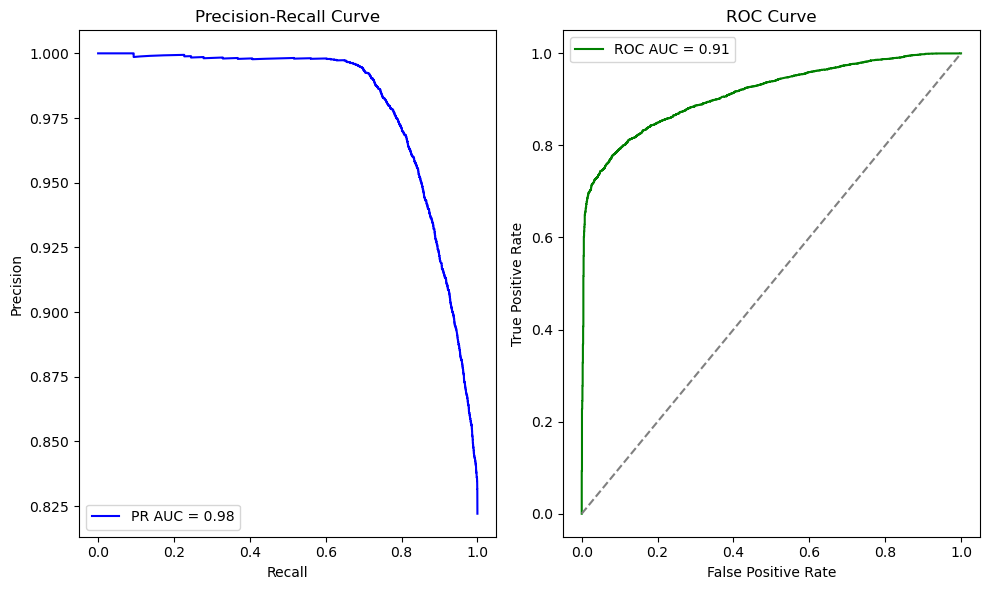

PR AUC: 0.98
ROC AUC: 0.91


In [77]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_7_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

## Bi-Directional LSTM

**Bidirectional LSTM** processes text sequences in both forward and backward directions, capturing context from past and future words simultaneously, which enhances the detection of nuanced language used in cyberbullying.

In [78]:
inputs = Input(shape=(1,), dtype=tf.string)
int_text_vectors = int_text_vectorizer(inputs)

token_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    mask_zero=True,
    trainable=False
)(int_text_vectors)

bidirectional_lstm_8 = Bidirectional(LSTM(64))(token_embeddings)
outputs_8 =  Dense(1, activation='sigmoid')(bidirectional_lstm_8)
model_8 = Model(inputs=inputs, outputs=outputs_8)


model_8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])

history_8 = model_8.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[early_stopping],
    epochs=10,
    verbose=1
)

Epoch 1/10
576/576 [==============================] - 18s 20ms/step - loss: 0.2838 - f1_m: 0.9146 - val_loss: 0.2649 - val_f1_m: 0.9124
Epoch 2/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2560 - f1_m: 0.9203 - val_loss: 0.2575 - val_f1_m: 0.9214
Epoch 3/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2502 - f1_m: 0.9236 - val_loss: 0.2550 - val_f1_m: 0.9223
Epoch 4/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2439 - f1_m: 0.9251 - val_loss: 0.2519 - val_f1_m: 0.9195
Epoch 5/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2407 - f1_m: 0.9260 - val_loss: 0.2612 - val_f1_m: 0.9214
Epoch 6/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2371 - f1_m: 0.9263 - val_loss: 0.2486 - val_f1_m: 0.9204
Epoch 7/10
576/576 [==============================] - 10s 17ms/step - loss: 0.2327 - f1_m: 0.9278 - val_loss: 0.2491 - val_f1_m: 0.9236
Epoch 8/10
576/576 [============================

In [79]:
model_8_pred_probs = model_8.predict(X_test)

threshold = 0.5
model_8_preds = (model_8_pred_probs >= threshold).astype(int)

# Generate classification report
report = classification_report(y_test, model_8_preds, target_names=['Class 0', 'Class 1'])
print(report)

# Store the results programmatically
report_dict = classification_report(y_test, model_8_preds, target_names=['Class 0', 'Class 1'], output_dict=True)

# Access specific metrics programmatically
accuracy = report_dict["accuracy"]
precision_class_0 = report_dict["Class 0"]["precision"]
recall_class_0 = report_dict["Class 0"]["recall"]
f1_class_0 = report_dict["Class 0"]["f1-score"]

288/288 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

     Class 0       0.66      0.52      0.58      1638
     Class 1       0.90      0.94      0.92      7566

    accuracy                           0.87      9204
   macro avg       0.78      0.73      0.75      9204
weighted avg       0.86      0.87      0.86      9204



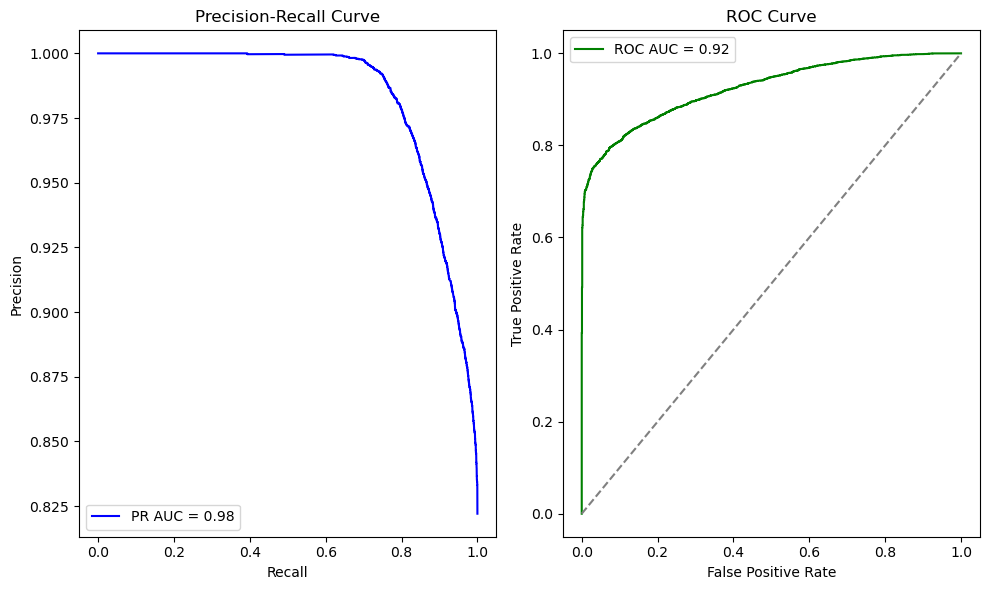

PR AUC: 0.98
ROC AUC: 0.92


In [80]:
# Call function to calculate PR and ROC AUC
pr_auc, roc_auc = calculate_pr_roc_auc(y_test, model_8_pred_probs)

# Print AUC results
print(f'PR AUC: {pr_auc:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')